### Generate and test feature likelihood SOM using comsoDC2 sample

We will be using the `cosmoDC2_v1.1.4_small_photoz_magerr_10y_small` sample, accessible via GCR. A description of this catalog is provided here:

https://confluence.slac.stanford.edu/display/LSSTDESC/List+of+available+DC2+catalogs+created+by+PhotoZ

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/python')

import os
import time
import som

import pandas as pd
import seaborn as sns

from astropy.table import Table
from matplotlib.colors import LogNorm

In [3]:
from GCR import GCRQuery
import GCRCatalogs

In [4]:
seed = 123
rng = np.random.RandomState(seed)

In [5]:
pz_path = '../data/feature_likelihood/'

Set `reload = True` if the catalog has already been written. Otherwise set to `False`.

In [6]:
reload = True

In [7]:
if reload:
    gc_table = Table.read(os.path.join(pz_path, 'dc2_small_photoz_magerr_10y_cuts.fits'), format='fits')
    dc2_colors = Table.read(os.path.join(pz_path, 'dc2_small_10y_colors.fits'), format='fits')
    
else:
    # Load catalog
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_photoz_magerr_10y')
    
    # Define coordinate cuts
    
    # 4 x 4 sq deg patch
    deg = 4 
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    alpha = 0.78 
    beta = (0.5 * deg) * (1/alpha - 1)

    ra_min = 62.5 - beta
    ra_max = 66.5 + beta
    dec_min = -41.
    dec_max = -37.

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]
    
    # Define magnitude cuts
    mag_filters = [
    'scatmag_u < 26.3',
    'scatmag_g < 26.3',
    'scatmag_r < 26.3',
    'scatmag_i < 25.0',
    ]
    
    # Add derived quantitites
    
    def get_colors(mag1, mag2):
        return(mag1 - mag2)

    # Diff between mag_<band>_true and mag_<band>_lsst?
    gc.add_derived_quantity('u-g_true', get_colors, 'mag_u_lsst', 'mag_g_lsst')
    gc.add_derived_quantity('g-r_true', get_colors, 'mag_g_lsst', 'mag_r_lsst')
    gc.add_derived_quantity('r-i_true', get_colors, 'mag_r_lsst', 'mag_i_lsst')
    gc.add_derived_quantity('i-z_true', get_colors, 'mag_i_lsst', 'mag_z_lsst')
    gc.add_derived_quantity('z-y_true', get_colors, 'mag_z_lsst', 'mag_y_lsst')

    gc.add_derived_quantity('u-g_scat', get_colors, 'scatmag_u', 'scatmag_g')
    gc.add_derived_quantity('g-r_scat', get_colors, 'scatmag_g', 'scatmag_r')
    gc.add_derived_quantity('r-i_scat', get_colors, 'scatmag_r', 'scatmag_i')
    gc.add_derived_quantity('i-z_scat', get_colors, 'scatmag_i', 'scatmag_z')
    gc.add_derived_quantity('z-y_scat', get_colors, 'scatmag_z', 'scatmag_y')
    
    gc_cut = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 
                            'mag_z_lsst', 'mag_y_lsst', 'scatmag_u', 'scatmag_g', 'scatmag_r', 'scatmag_i', 
                           'scatmag_z', 'scatmag_y', 'scaterr_u', 'scaterr_g', 'scaterr_r', 'scaterr_i', 
                           'scaterr_z', 'scaterr_y', 'u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 
                           'u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat'], 
                           filters=(coord_filters + mag_filters))
    # Write catalog
    gc_table = Table(gc_cut)
    gc_table.write(os.path.join(pz_path, 'dc2_small_photoz_magerr_10y_cuts.fits'), format='fits')
    
    # Write colors table
    colors = np.asarray([gc_cut['u-g_true'], gc_cut['g-r_true'], gc_cut['r-i_true'], gc_cut['i-z_true'], gc_cut['z-y_true']]).T
    dc2_colors = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    dc2_colors.write(os.path.join(pz_path, 'dc2_small_10y_colors.fits'), format='fits')

#### Let's take a look at the data post-cuts:

In [9]:
gc_df = pd.DataFrame(np.array(gc_table))
gc_size = len(gc_df['redshift'])

print('There are {} galaxies left after magnitude and ra/dec cuts.'.format(gc_size))
# Want to be around 50-60 per sq arcmin
print('There are {} targets per sq arcmin.'.format(gc_size / (16 * 3600)))

There are 1613192 galaxies left after magnitude and ra/dec cuts.
There are 28.006805555555555 targets per sq arcmin.


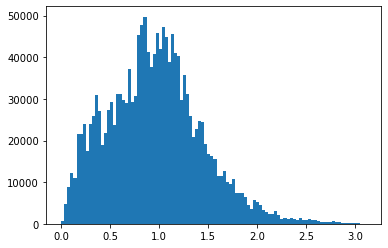

In [10]:
# Check for stars
plt.hist(gc_df['redshift'], bins=100);

Add a digitized redshift column:

In [11]:
nzbins = 10
zbins = np.percentile(gc_df['redshift'], np.linspace(0, 100, nzbins + 1))
zbins[-1] += 1
iz = np.digitize(gc_df['redshift'], zbins) - 1
assert np.all((iz >= 0) & (iz < nzbins))
gc_df['iz'] = iz

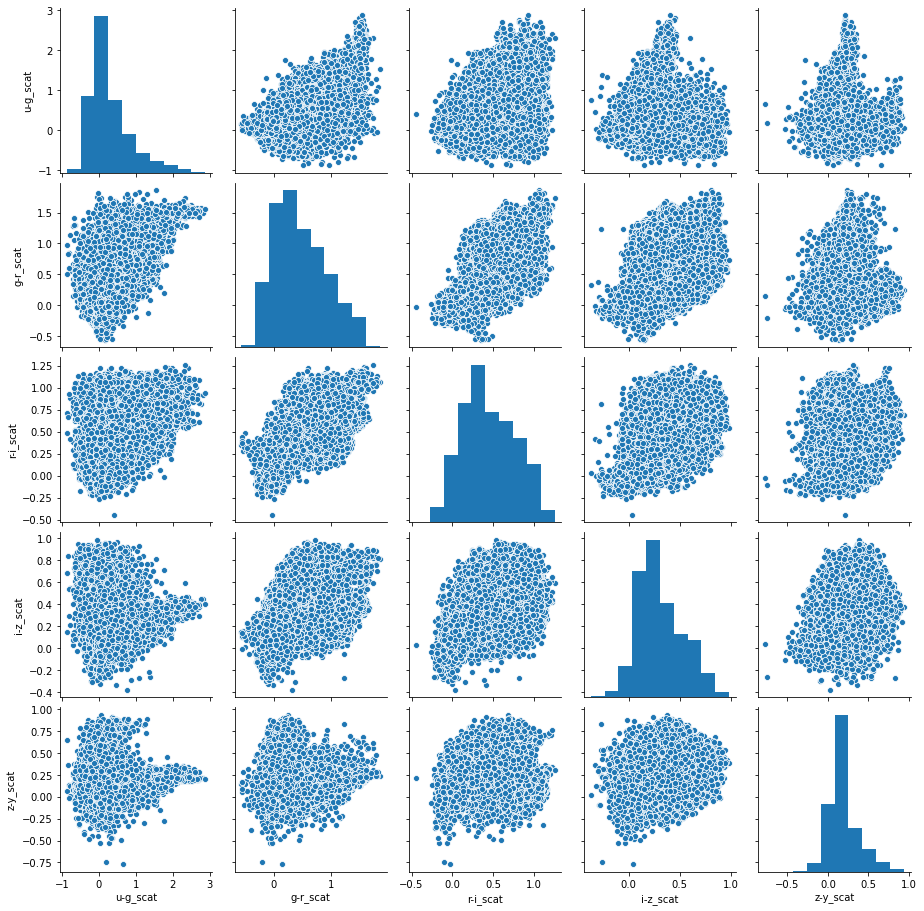

In [18]:
# Magnitude cuts look reasonable...
sns.pairplot(gc_df[['u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat']][::100]);

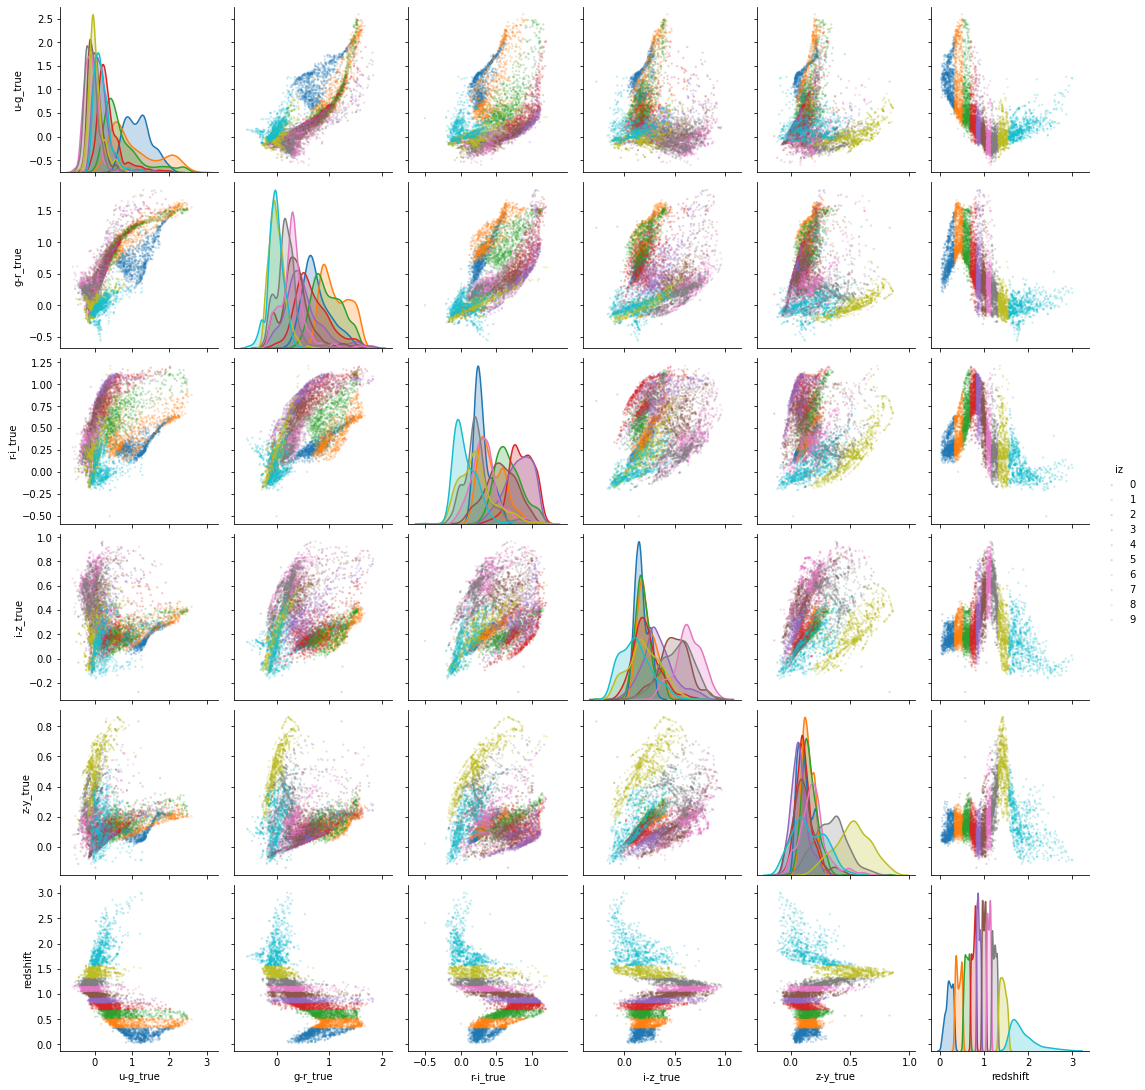

In [19]:
sns.pairplot(gc_df[::200], vars=['u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 'redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

Make SOM inputs using only 3 colors:

In [8]:
griz_colors = np.asarray([gc_table['g-r_true'], gc_table['r-i_true'], gc_table['i-z_true']]).T
dc2_griz_colors = Table(griz_colors, names=['g-r', 'r-i', 'i-z'])

In [19]:
X = dc2_griz_colors[::50]
Y = np.array(gc_table['redshift'])[::50]

In [20]:
nside = 15
niter = 5

In [23]:
som_pz = som.SelfOrganizingMap(som.Grid(-nside,-nside))
som_pz.fit(X, maxiter=niter, eta=0.5)
som_pz.map_to_som(X, Y)

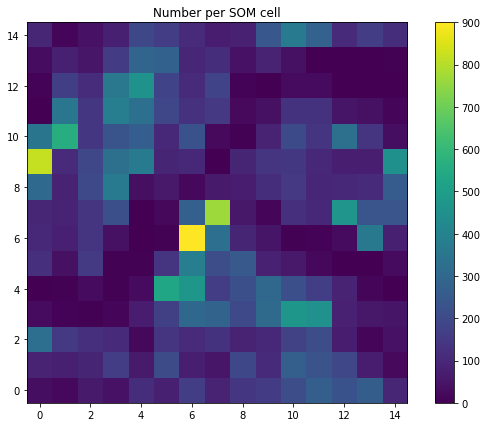

In [25]:
som_pz.plot_counts_per_cell(X)

#### Divide catalog into training and test sets:

In [9]:
# Make train/test split to be roughly 70%/30%:
int(.7 * gc_size)

1129234

In [9]:
train_mask = np.zeros(gc_size, dtype=bool)
train_size = int(.7 * gc_size)
train_indices = rng.choice(gc_size, size=train_size, replace=False)
train_mask[train_indices] = True

In [10]:
train = gc_df.loc[train_mask]
test = gc_df.loc[~train_mask]

print(len(train), len(test))

1129234 483958


#### 1) Build a SOM from a training subset of the catalog

- Use truth colors for training

- Note on choice of features: pheno-z paper uses 8 lupticolors (based on asinh magnitudes) all with respect to i-band

- For this example, use all truth colors

In [9]:
random_sample = rng.uniform(high=10.0, size=(131000,3))

129.60226202011108


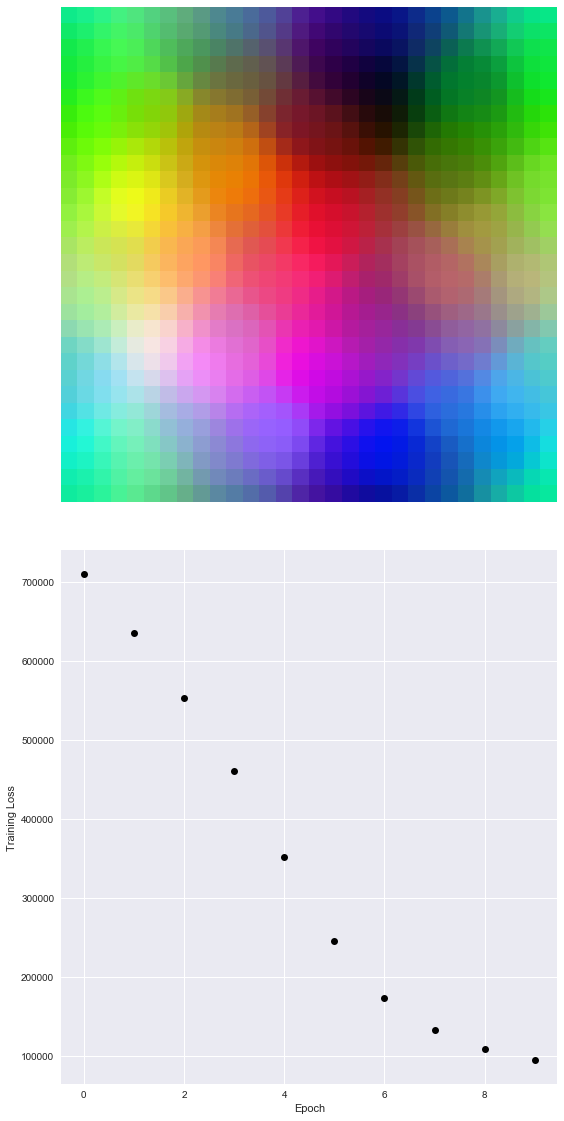

In [10]:
start = time.time()
rndm_som = som.make_som(random_sample[::50], nmap=-30, niter=10, rgb=[0,1,2])
print(time.time() - start)

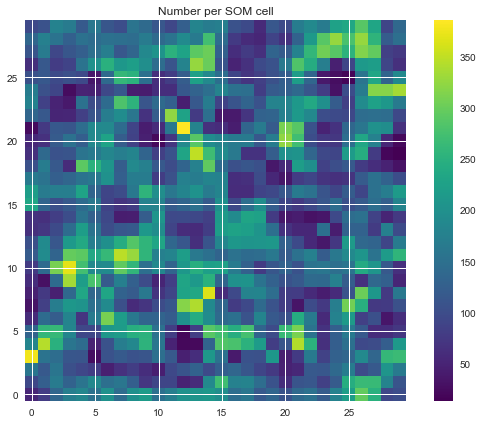

In [12]:
som.plot_counts_per_cell(random_sample, rndm_som[0])

In [13]:
rndm_indices, rndm_counts = som.map_phot_to_som(random_sample, rndm_som[0])

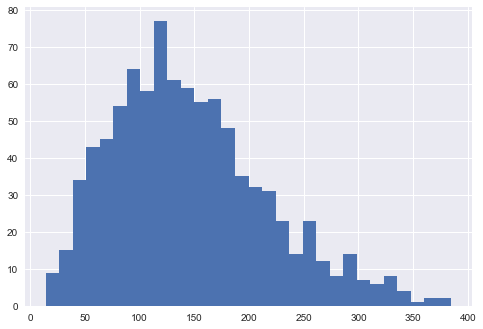

In [32]:
plt.hist(rndm_counts, bins=30);

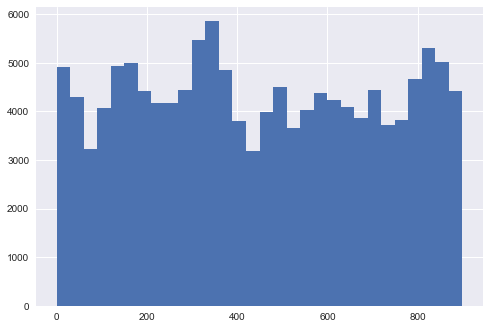

In [34]:
plt.hist(rndm_indices, bins=30);

In [8]:
random_sample = rng.uniform(size=(131000,3))

2.779353141784668


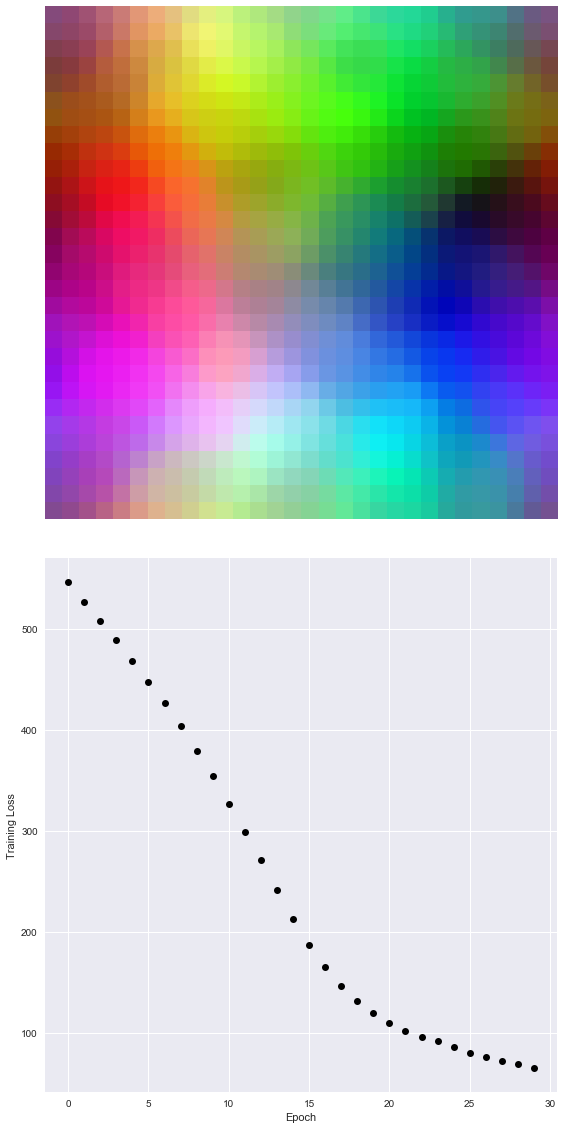

In [9]:
start = time.time()
rndm_som = som.make_som(random_sample[:1000], nmap=-30, niter=30, rgb=[0,1,2])
print(time.time() - start)

1000 galaxies

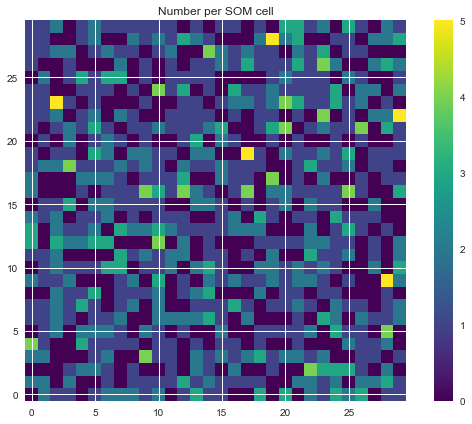

In [67]:
som.plot_counts_per_cell(random_sample[:1000], rndm_som[0])

In [68]:
rndm_indices, rndm_counts = som.map_phot_to_som(random_sample[:1000], rndm_som[0])

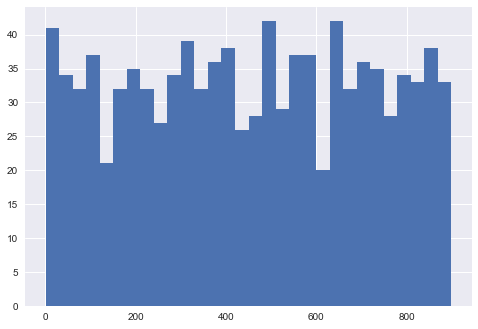

In [69]:
plt.hist(rndm_indices, bins=30);

6


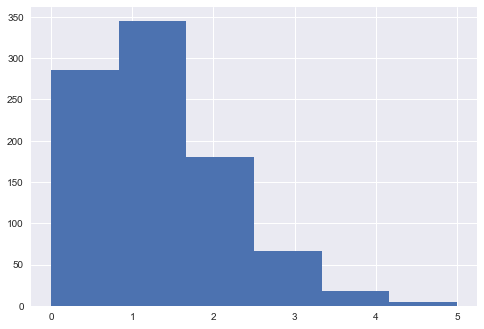

In [83]:
plt.hist(rndm_counts, bins=6)
print(len(np.unique(rndm_counts)))

20000 galaxies

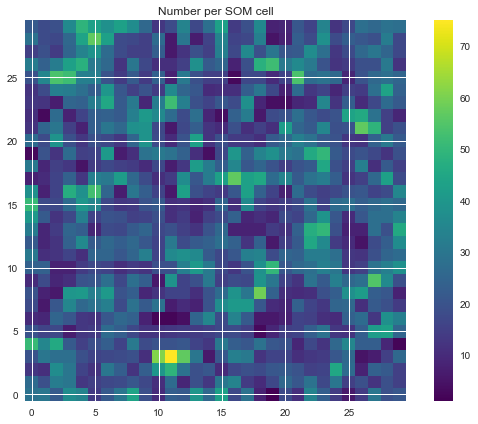

In [59]:
som.plot_counts_per_cell(random_sample[:20000], rndm_som[0])

In [60]:
rndm_indices, rndm_counts = som.map_phot_to_som(random_sample[:20000], rndm_som[0])

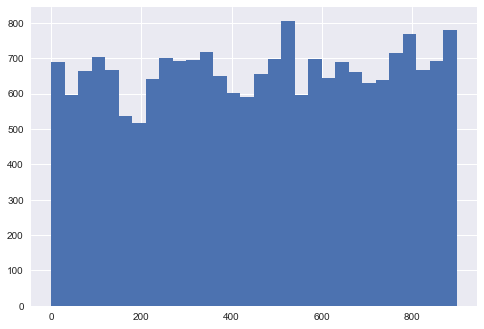

In [61]:
plt.hist(rndm_indices, bins=30);

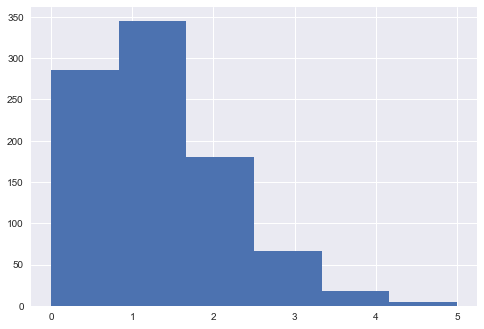

In [82]:
plt.hist(rndm_counts, bins=6);

1.44883394241333


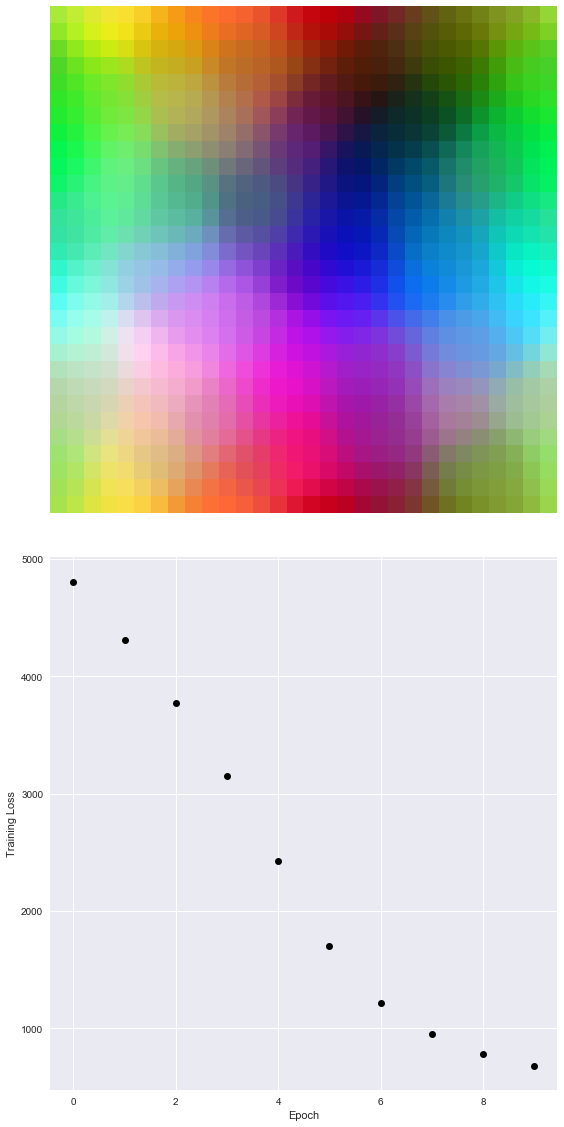

In [98]:
start = time.time()
rndm_som = som.make_som(random_sample, nmap=-30, niter=10, rgb=[0,1,2], 
                       seed=14)
print(time.time() - start)

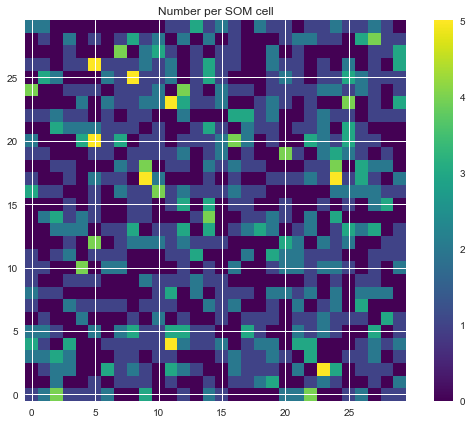

In [99]:
som.plot_counts_per_cell(random_sample, rndm_som[1])

0.7597110271453857


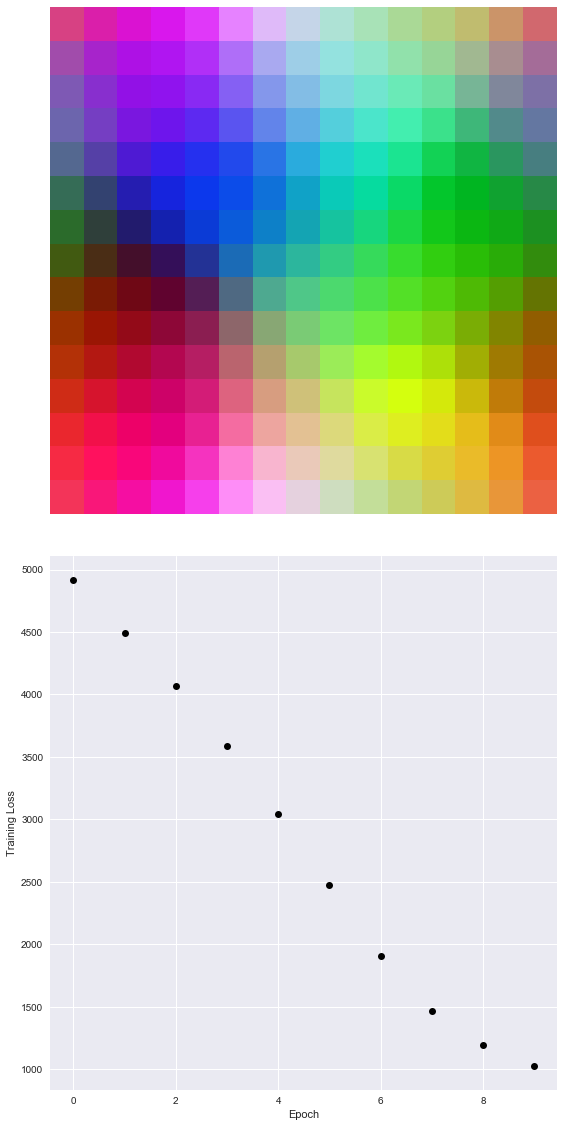

In [25]:
start = time.time()
rndm_som = som.make_som(random_sample, nmap=-15, niter=10, rgb=[0,1,2], 
                       seed=14)
print(time.time() - start)

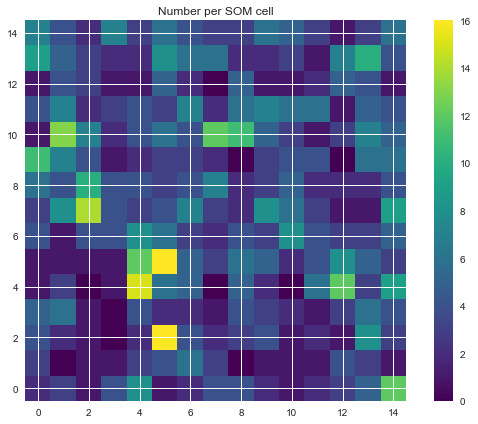

In [26]:
som.plot_counts_per_cell(random_sample, rndm_som[1])

0.46425414085388184


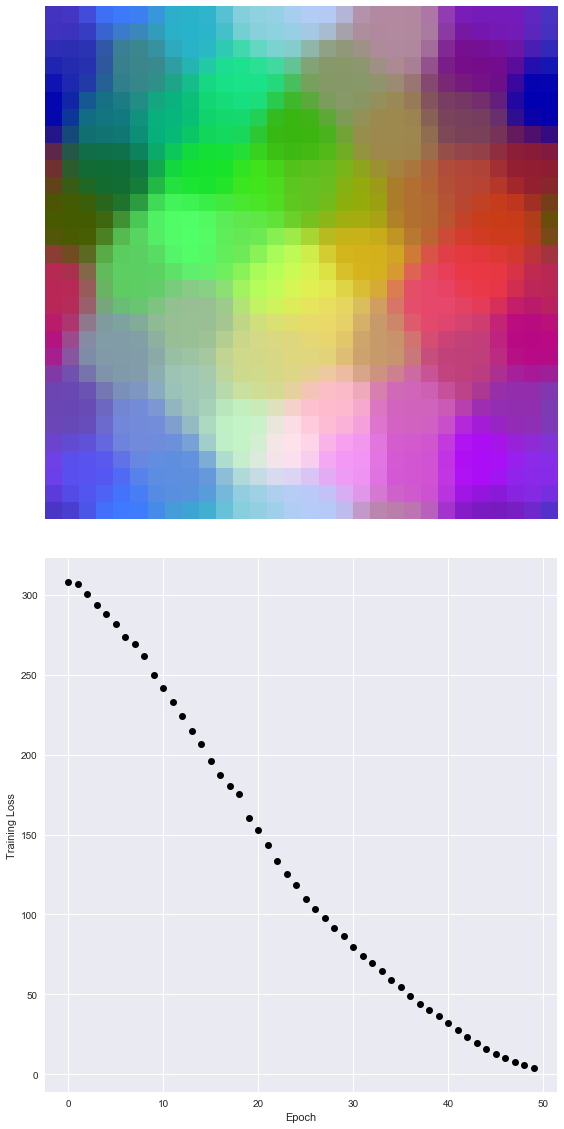

In [27]:
start = time.time()
rndm_som_rgb = som.make_som(random_sample[::15], nmap=-30, niter=50, rgb=[0,1,2])
print(time.time() - start)

0.4880859851837158


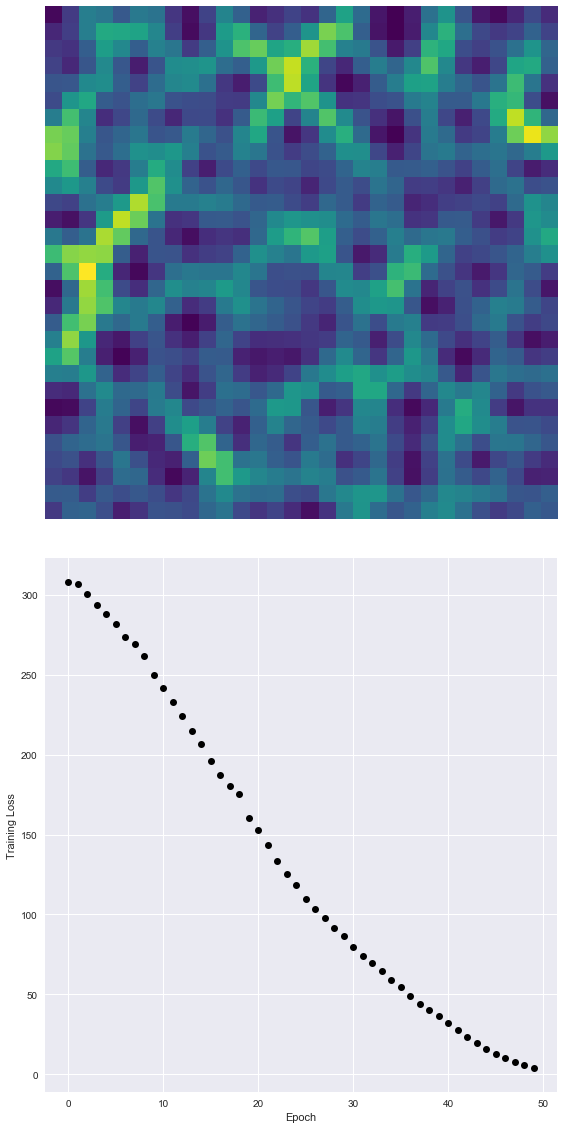

In [28]:
start = time.time()
rndm_som_umatrix = som.make_som(random_sample[::15], nmap=-30, niter=50, rgb=None)
print(time.time() - start)

Map random sample back to SOM:

In [36]:
np.all(rndm_som_rgb[1] == rndm_som_umatrix[1])

True

In [11]:
start = time.time()
temp_indices = som.map_phot_to_som(random_sample[::15], rndm_som[0])
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, 30, 30)

0.15234708786010742


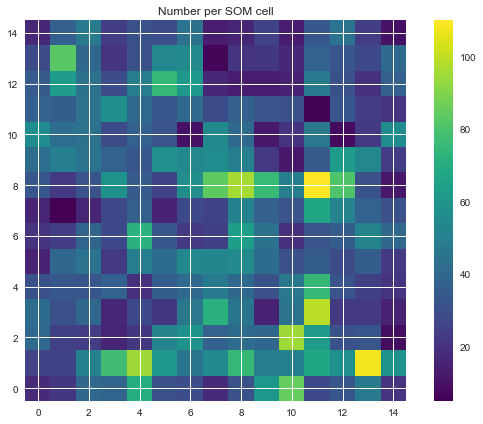

In [12]:
som.plot_counts_per_cell(random_sample[::15], rndm_som[0])

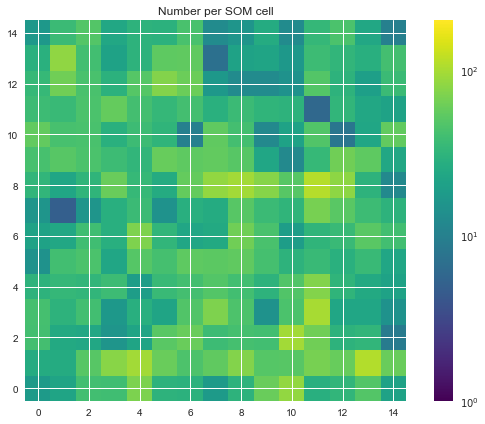

In [13]:
som.plot_counts_per_cell(random_sample[::15], rndm_som[0], 
                        norm=LogNorm(vmin=1, vmax=200))

### DC2 data

In [136]:
n_train

1129234

In [42]:
s._corrections.shape

(15, 32264, 3, 2500)

Possible test: plot correction with respect to proximity to bmu - large values should corresond to points closer to bmu, smaller corrections should correspond to points that are further away.

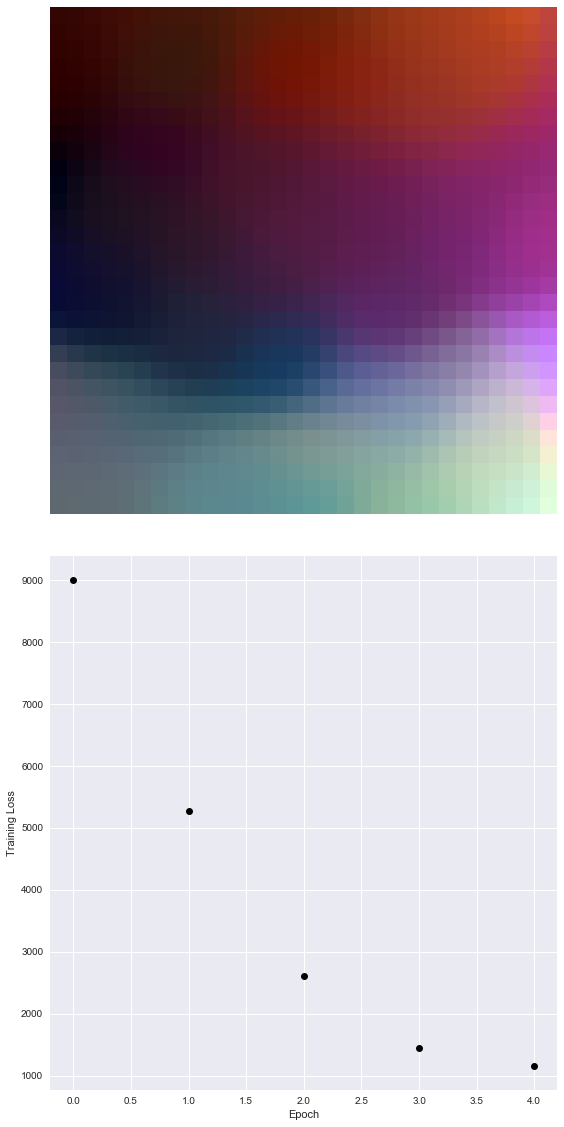

In [251]:
s, weights = som.make_som(dc2_griz_colors[::50], 
                                         nmap=30, eta=0.5, niter=5,
                                         rgb=[0,1,2])

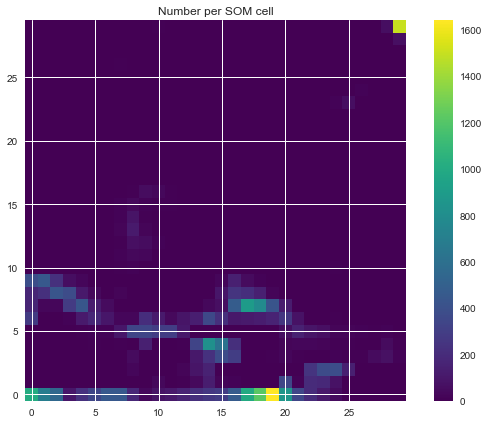

In [252]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights, 
                         norm=None)

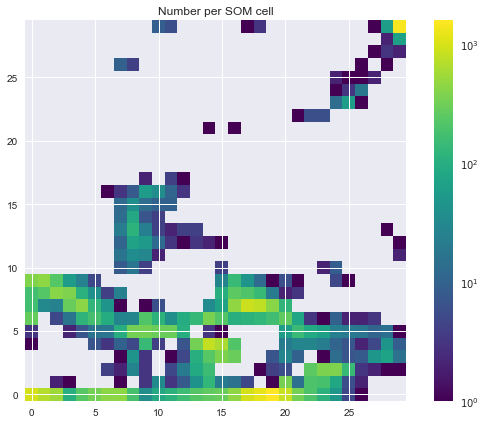

In [253]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights, 
                         norm=LogNorm(vmin=1, vmax=1600))

In [254]:
s_indices, s_counts = som.map_phot_to_som(dc2_griz_colors[::50], weights)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2917: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


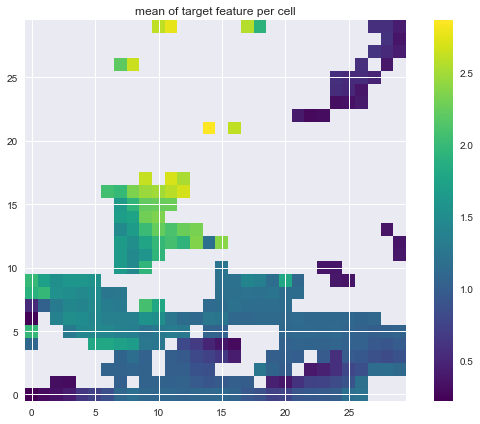

In [255]:
som.plot_statistic(s_indices, s_counts, gc_table[::50]['redshift'], 30, 30, statistic=np.mean)

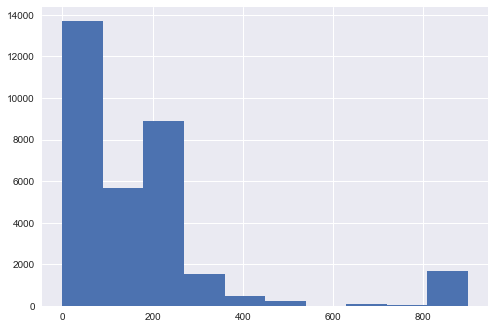

In [256]:
plt.hist(s_indices);

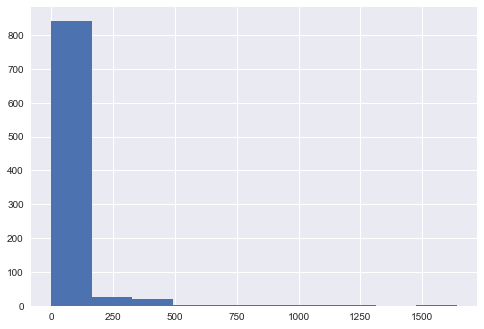

In [257]:
plt.hist(s_counts);

<IPython.core.display.Javascript object>


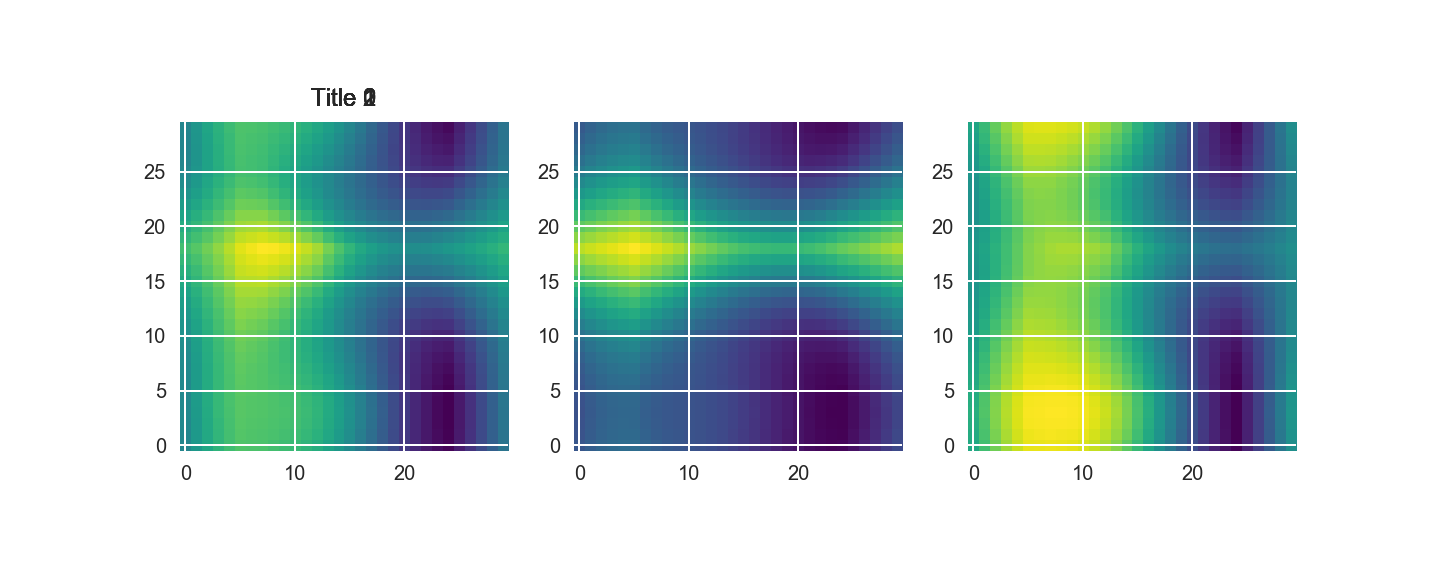

In [30]:
%matplotlib notebook
import matplotlib.animation as animation

fig, axs = plt.subplots(1,3, figsize=(10,4))
axs = axs.ravel()

container0 = []
container1 = []
container2 = []
for i in range(3): #np.arange(0,niter,1):
    for j in range(3):#np.arange(0,ndata,2000):
        im0 = axs[0].imshow(s._all_weights[i,j, 0].reshape(xside, xside), 
                        origin='lower', interpolation='none',
                        cmap='viridis', animated=True)
        im1 = axs[1].imshow(s._all_weights[i,j, 1].reshape(xside, xside), 
                        origin='lower', interpolation='none',
                        cmap='viridis', animated=True)
        im2 = axs[2].imshow(s._all_weights[i,j, 2].reshape(xside, xside), 
                        origin='lower', interpolation='none',
                        cmap='viridis', animated=True)
        
        #cb0 = fig.colorbar(im0, cax=axs[0])
        #cb1 = fig.colorbar(im1, cax=axs[1])
        #cb2 = fig.colorbar(im2, cax=axs[2])
        
        title0 = axs[0].text(0.5,1.05,"Title {}".format(i), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=axs[0].transAxes, )
        #cbar0 = fig.colorbar(im0, cax=axs[0])
        
        container0.append([im0, title0])
        container1.append([im1])
        container2.append([im2])
        
        
        #tx0 = axs[0].set_title('g-r weights')
        #tx1 = axs[1].set_title('r-i band weights')
        #tx2 = axs[2].set_title('i-z band weights')
        
        #plt.suptitle('epoch = {}, data index = {}'.format(i,j))
        
        #ims0.append([im0])
        #ims1.append([im1])
        #ims2.append([im2])
        

ani0 = animation.ArtistAnimation(fig, ims0, interval=1000, blit=True,
                                repeat_delay=2000)
ani1 = animation.ArtistAnimation(fig, ims1, interval=1000, blit=False,
                                repeat_delay=1000)
ani2 = animation.ArtistAnimation(fig, ims2, interval=1000, blit=False,
                                repeat_delay=0)

#ani0.save('test0.mp4')

plt.show()

12.855404138565063


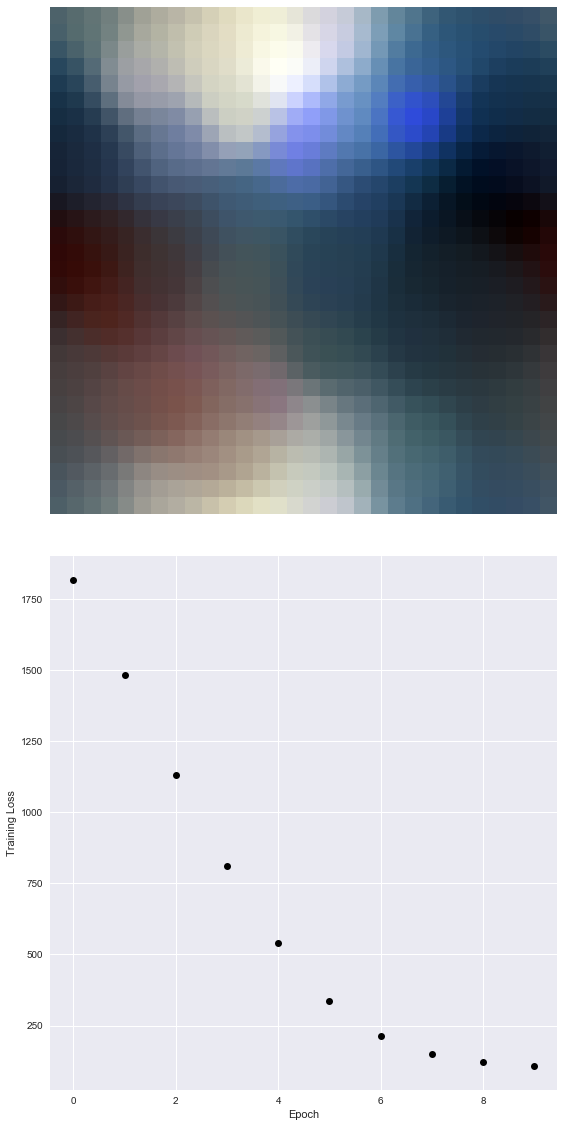

In [260]:
n_train = int(.7 * len(dc2_griz_colors))
start = time.time()
s, temp_weights = som.make_som(dc2_griz_colors[:10000], nmap=-30, eta=0.5, 
                               niter=10, rgb=[0,1,2])
print(time.time()-start)

A plot of the weights should show a clear gradient with no edges since boundary conditions are periodic:

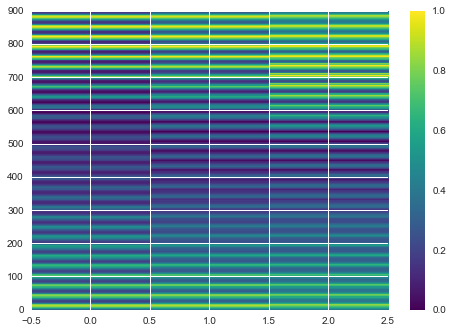

In [261]:
plt.imshow(temp_weights, origin='lower', interpolation='none', aspect='auto', cmap='viridis')
plt.colorbar();

In [263]:
temp_indices, temp_counts = som.map_phot_to_som(dc2_griz_colors[:10000], temp_weights)

In [264]:
print('There are {} non-empty cells.'.format(len(np.unique(temp_indices))))

There are 98 non-empty cells.


### W/ errors (ignore for now - just as a sanity check to confirm SOM is working properly)

In [234]:
griz_colors_errs = np.asarray([gc_table['scatmag_g-r'], gc_table['scatmag_r-i'], gc_table['scatmag_i-z']]).T
dc2_griz_colors_errs = Table(griz_colors_errs, names=['g-r', 'r-i', 'i-z'])

In [237]:
data_arr_errs = np.zeros((len(dc2_griz_colors_errs),len(dc2_griz_colors_errs.colnames)))
for k, name in enumerate(dc2_griz_colors_errs.colnames):
    data_arr_errs[:,k] = dc2_griz_colors_errs[name]
data_arr_errs = (data_arr_errs - np.min(data_arr_errs, axis=0)) / (np.max(data_arr_errs, axis=0) - 
                                                              np.min(data_arr_errs, axis=0))

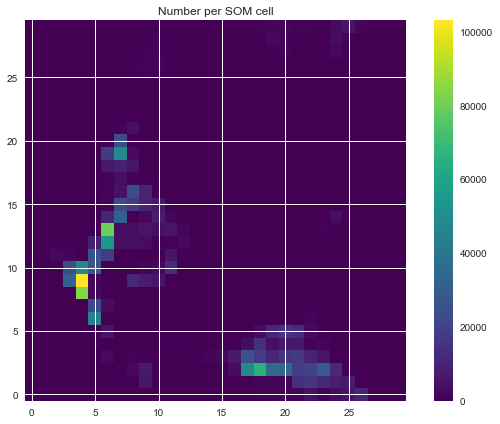

In [238]:
rows, cols, D = temp_som.shape
test_griz_errs = data_arr_errs
temp_indices_errs, temp_counts_errs = som.map_phot_to_som(test_griz_errs, temp_weights.reshape(rows, cols, D))
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

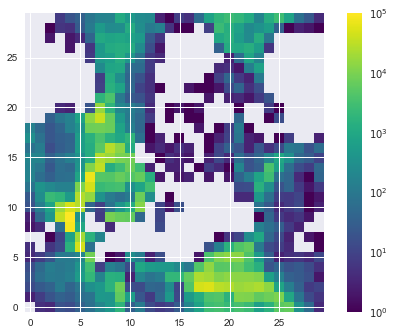

In [245]:
plt.imshow(temp_counts_errs.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis', 
           norm=LogNorm(vmin=1, vmax=100000))
plt.colorbar();

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2917: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


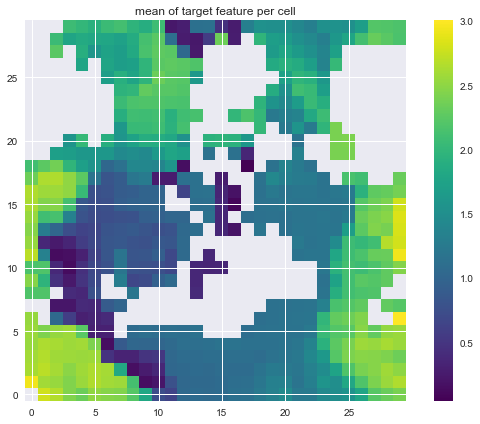

In [240]:
som.plot_statistic(temp_indices_errs, temp_counts_errs, gc_table['redshift'], rows, cols)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


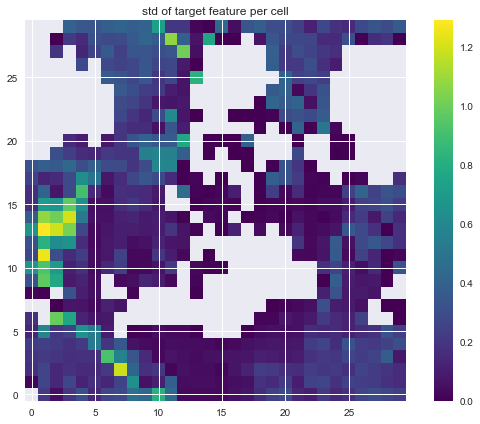

In [241]:
som.plot_statistic(temp_indices_errs, temp_counts_errs, gc_table['redshift'], rows, cols, np.std)

### Add one more feature: now using four colors

In [33]:
ugriz_colors = np.asarray([gc_table['u-g_true'], gc_table['g-r_true'], gc_table['r-i_true'], gc_table['i-z_true']]).T
dc2_ugriz_colors = Table(ugriz_colors, names=['u-g', 'g-r', 'r-i', 'i-z'])

In [ ]:
n_train = int(.7 * len(dc2_ugriz_colors))
start = time.time()
s_ugriz, temp_weights_ugriz, temp_evol_weights_ugriz, temp_som_ugriz = som.make_som(dc2_ugriz_colors[:10000], 
                                                         nmap=-30, eta=0.5, niter=200,
                                                         rgb=[0,1,2])
print(time.time()-start)

In [ ]:
save = False
if save:
    np.save('som_data/weights_1129234_30x30_0.5_200_ugriz', temp_weights_ugriz)
    np.save('som_data/evol_weights_1129234_30x30_0.5_200_ugriz', temp_evol_weights_ugriz)
    np.save('som_data/som_1129234_30x30_0.5_200_ugriz', temp_som_ugriz)

In [259]:
data_arr_ugriz = np.zeros((len(dc2_ugriz_colors),len(dc2_ugriz_colors.colnames)))
for k, name in enumerate(dc2_ugriz_colors.colnames):
    data_arr_ugriz[:,k] = dc2_ugriz_colors[name]
data_arr_ugriz = (data_arr_ugriz - np.min(data_arr_ugriz, axis=0)) / (np.max(data_arr_ugriz, axis=0) - 
                                                              np.min(data_arr_ugriz, axis=0))

Compare trained weights with weights trained using only 3 colors:

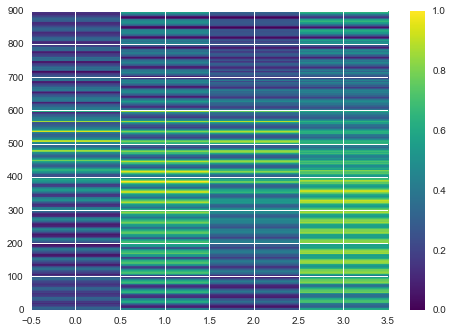

In [427]:
plt.imshow(temp_weights_ugriz, origin='lower', interpolation='none', aspect='auto', cmap='viridis')
plt.colorbar();

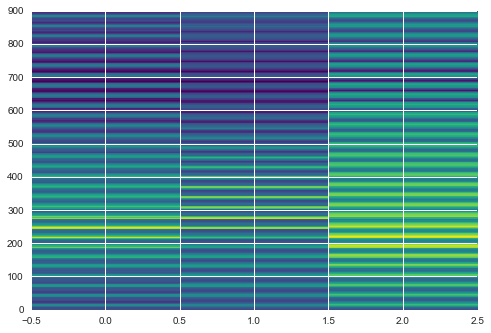

In [353]:
plt.imshow(temp_weights, origin='lower', interpolation='none', aspect='auto', cmap='viridis');

Ok, they look pretty similar. 

Now map data back to SOM:

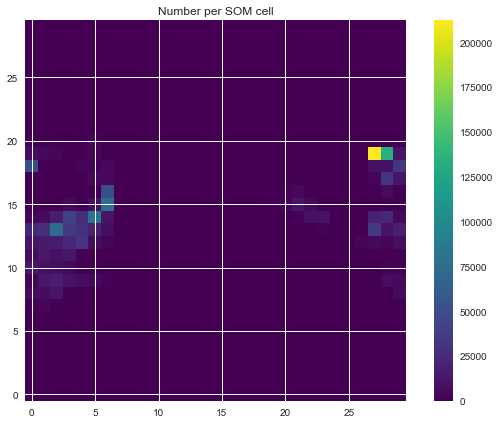

In [260]:
rows, cols, D = temp_som_ugriz.shape
temp_indices_ugriz, temp_counts_ugriz = som.map_phot_to_som(data_arr_ugriz, temp_som_ugriz)
som.plot_counts_per_cell(temp_indices_ugriz, temp_counts_ugriz, rows, cols)

### View on log scale

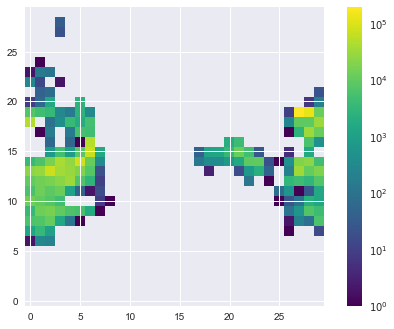

In [264]:
plt.imshow(temp_counts_ugriz.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis', 
           norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar();

This looks pretty different from 3-color version. 

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2917: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


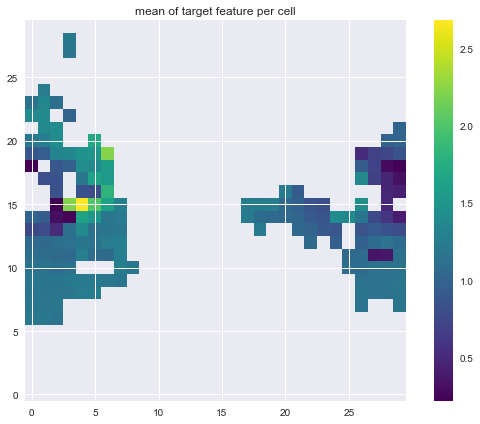

In [266]:
som.plot_statistic(temp_indices_ugriz, temp_counts_ugriz, gc_table['redshift'], rows, cols)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


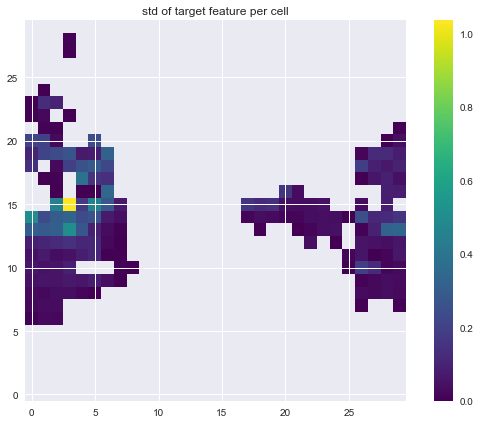

In [267]:
som.plot_statistic(temp_indices_ugriz, temp_counts_ugriz, gc_table['redshift'], rows, cols, statistic=np.std)

In [366]:
print('There are {} non-empty cells.'.format(len(np.unique(temp_indices_ugriz))))

There are 177 non-empty cells.


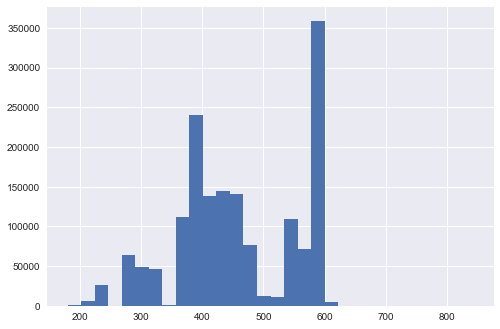

In [416]:
plt.hist(temp_indices_ugriz, bins=30);

### Add another color: up to 5 colors now

In [21]:
ugrizy_colors = np.asarray([gc_table['u-g_true'], gc_table['g-r_true'], gc_table['r-i_true'], gc_table['i-z_true'], 
                          gc_table['z-y_true']]).T
dc2_ugrizy_colors = Table(ugrizy_colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])

58.80801701545715


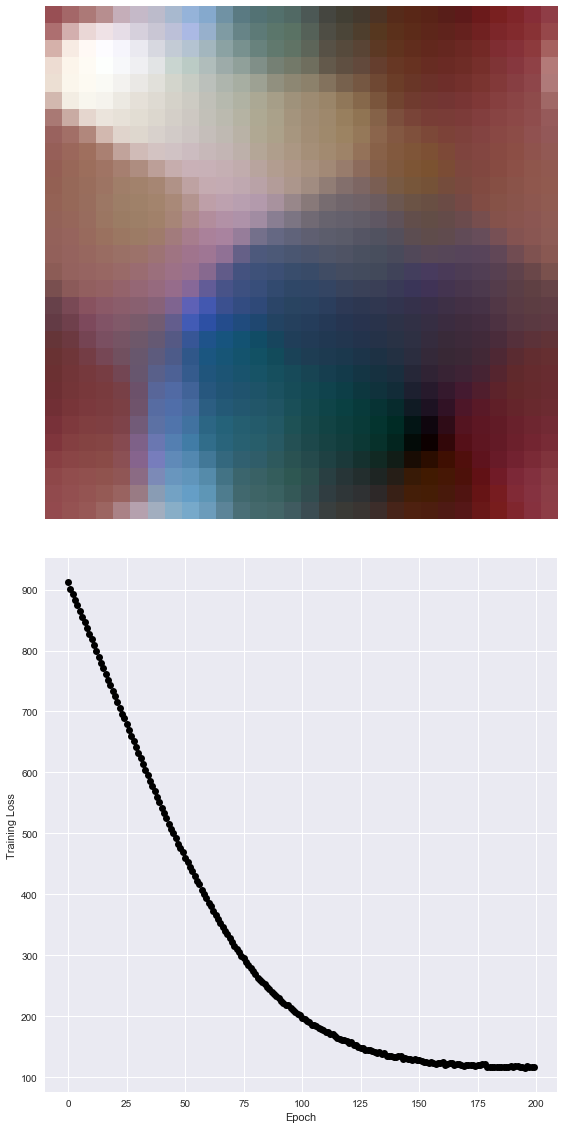

In [48]:
n_train = int(.7 * len(dc2_ugrizy_colors))
start = time.time()
s_ugrizy, temp_weights_ugrizy, temp_evol_weights_ugrizy, temp_som_ugrizy = som.make_som(dc2_ugrizy_colors[:5000], 
                                                         nmap=-30, eta=0.5, niter=200,
                                                         evolve_freq=1, 
                                                         rgb=[0,1,2])
print(time.time()-start)

In [29]:
np.min(s._loss),  np.min(s_ugriz._loss), np.min(s_ugrizy._loss)

(51.55877234871324, 105.78890901292296, 115.68185142425553)

In [30]:
np.max(s._loss),  np.max(s_ugriz._loss), np.max(s_ugrizy._loss)

(520.8528401506137, 882.5953528204049, 911.6155035480476)

In [512]:
np.save('som_data/weights_1129234_30x30_0.5_200_ugrizy', temp_weights_ugrizy)
np.save('som_data/evol_weights_1129234_30x30_0.5_200_ugrizy', temp_evol_weights_ugrizy)
np.save('som_data/som_1129234_30x30_0.5_200_ugrizy', temp_som_ugrizy)

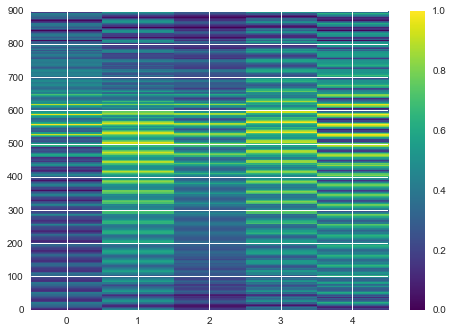

In [426]:
plt.imshow(temp_weights_ugrizy, origin='lower', interpolation='none', aspect='auto', cmap='viridis')
plt.colorbar();

In [358]:
data_arr_ugrizy = np.zeros((len(dc2_ugrizy_colors),len(dc2_ugrizy_colors.colnames)))
for k, name in enumerate(dc2_ugrizy_colors.colnames):
    data_arr_ugrizy[:,k] = dc2_ugrizy_colors[name]
data_arr_ugrizy = (data_arr_ugrizy - np.min(data_arr_ugrizy, axis=0)) / (np.max(data_arr_ugrizy, axis=0) - 
                                                              np.min(data_arr_ugrizy, axis=0))

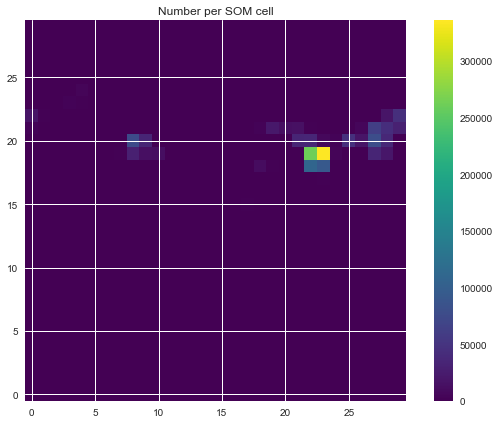

In [359]:
rows, cols, D = temp_som_ugrizy.shape
temp_indices_ugrizy, temp_counts_ugrizy = som.map_phot_to_som(data_arr_ugrizy, temp_som_ugrizy)
som.plot_counts_per_cell(temp_indices_ugrizy, temp_counts_ugrizy, rows, cols)

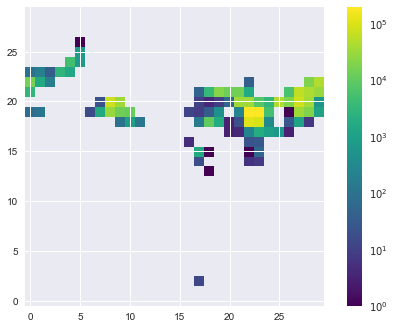

In [360]:
plt.imshow(temp_counts_ugrizy.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis', 
           norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar();

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2917: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


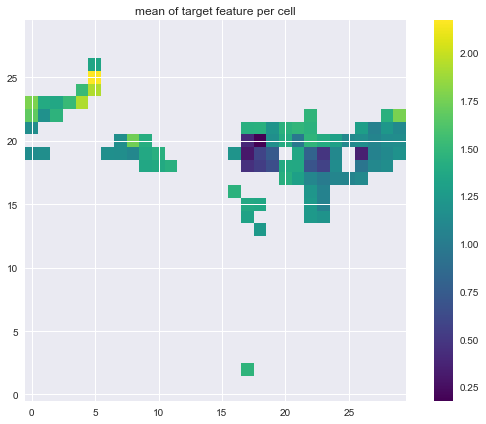

In [362]:
som.plot_statistic(temp_indices_ugrizy, temp_counts_ugrizy, gc_table['redshift'], rows, cols)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


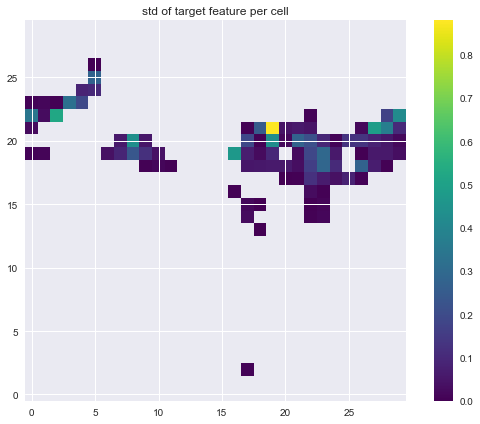

In [363]:
som.plot_statistic(temp_indices_ugrizy, temp_counts_ugrizy, gc_table['redshift'], rows, cols, statistic=np.std)

In [365]:
print('There are {} non-empty cells.'.format(len(np.unique(temp_indices_ugrizy))))

There are 94 non-empty cells.


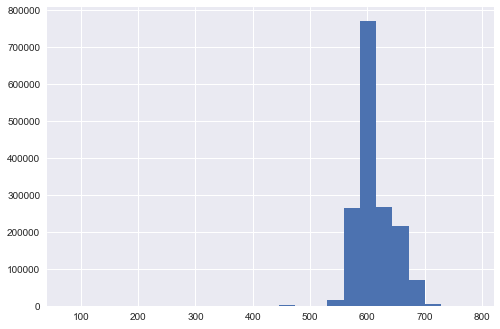

In [421]:
plt.hist(temp_indices_ugrizy, bins=25);

### DEBUG

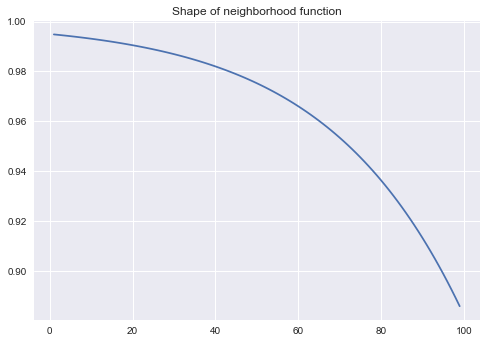

In [43]:
gw = 5 ** (1 - np.arange(1,100)/100)
plt.plot(np.arange(1,100), np.exp(-0.5 * (.5 / gw) ** 2))
plt.title('Shape of neighborhood function');

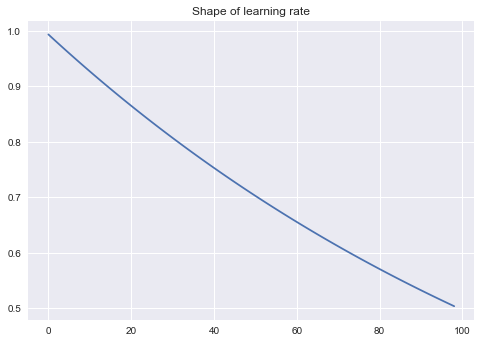

In [44]:
plt.plot(0.5 ** (np.arange(1,100) / 100))
plt.title('Shape of learning rate');

In [71]:
random_sample = rng.uniform(size=(1000,3))

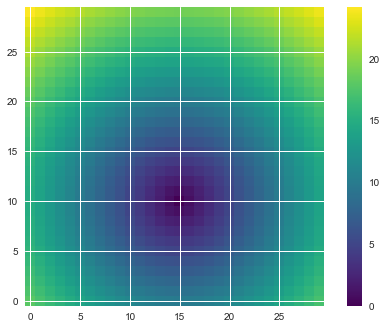

In [125]:
plt.imshow(rndm_som._mapgeom.separations[315].reshape(30,30), origin='lower', cmap='viridis')
plt.colorbar();

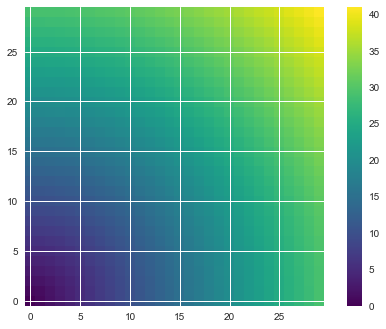

In [126]:
plt.imshow(rndm_som._mapgeom.separations[0].reshape(30,30), origin='lower', cmap='viridis')
plt.colorbar();

2.0171079635620117


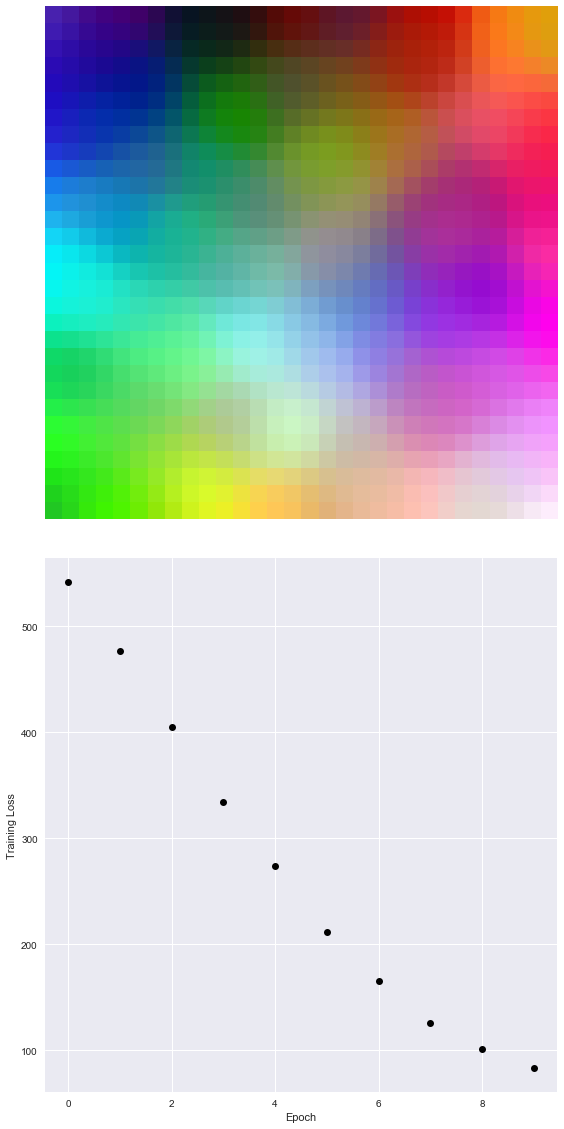

In [124]:
eta = 0.5
sigma_frac = 1.0
start = time.time()
rndm_som, rndm_weights = som.make_som(random_sample, nmap=30, niter=10, rgb=[0,1,2], eta=eta, 
                                     sigma_frac=sigma_frac)
print(time.time() - start)

1.6005198955535889


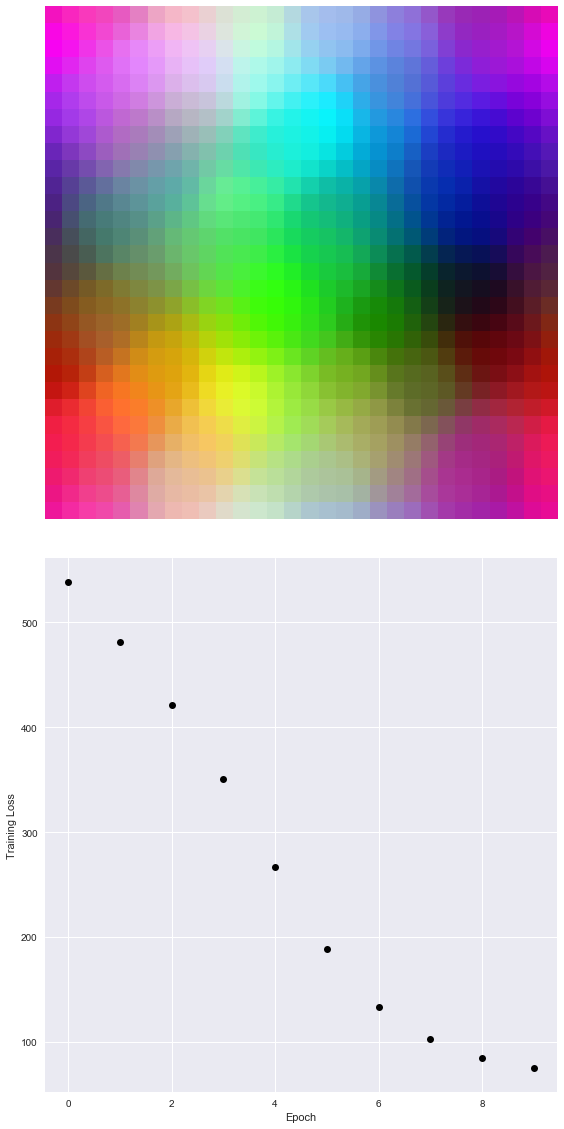

In [102]:
eta = 0.5
start = time.time()
rndm_som, rndm_weights = som.make_som(random_sample, nmap=-30, niter=10, rgb=[0,1,2], eta=eta)
print(time.time() - start)

The learning rate should control how quickly weights change in time, and the sigma for the update rule should control the spatial scale of changes:

In [12]:
def plot_evolution(trained_som, nepoch, ndata, cell, eta=0.5):
    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs = axs.ravel()
    
    axs[0].plot(trained_som._all_weights[::nepoch,::ndata,0,cell].reshape(-1), label='g-r')
    axs[0].plot(trained_som._all_weights[::nepoch,::ndata,1,cell].reshape(-1), label='r-i')
    axs[0].plot(trained_som._all_weights[::nepoch,::ndata,2,cell].reshape(-1), label='i-z')
    axs[0].set_ylabel('weight value')
    axs[0].set_xlabel('every {} epochs, every {} data vectors'.format(nepoch, ndata))
    axs[0].set_title('Learning rate = {}, sigma = {}, cell = {}'.format(eta, 
                                                                        trained_som._scale.astype(float16), cell))
    axs[0].legend()
    
    axs[1].plot(trained_som._corrections[::nepoch,::ndata,0,cell].reshape(-1), label='g-r')
    axs[1].plot(trained_som._corrections[::nepoch,::ndata,1,cell].reshape(-1), label='r-i')
    axs[1].plot(trained_som._corrections[::nepoch,::ndata,2,cell].reshape(-1), label='i-z')
    axs[1].set_ylabel('correction')
    axs[1].set_xlabel('every {} epochs, every {} data vectors'.format(nepoch, ndata))
    axs[1].set_title('Learning rate = {}, sigma = {}, cell = {}'.format(eta, 
                                                                        trained_som._scale.astype(float16), cell))
    axs[1].legend();

First look at how changing the learning rate affects the evolution of weights:

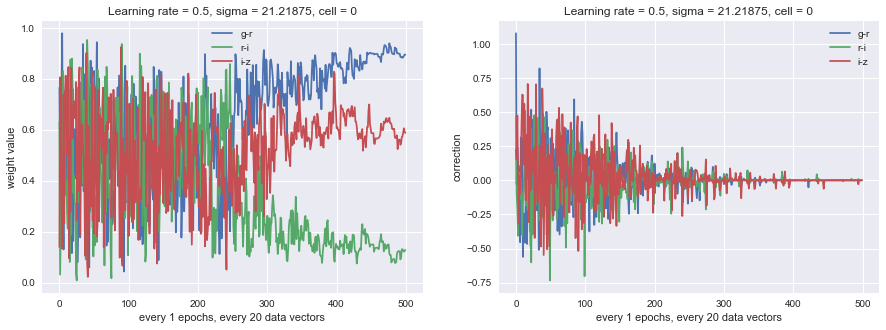

In [27]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=0, eta=0.5)

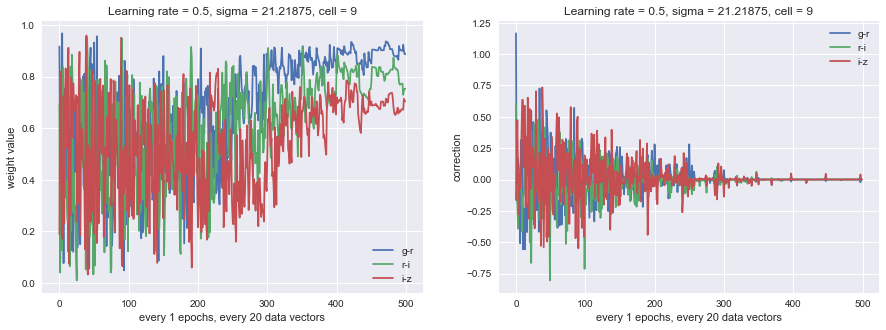

In [31]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=9, eta=0.5)

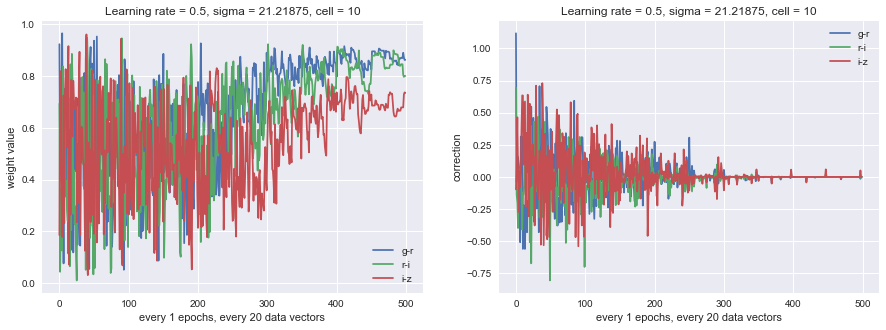

In [29]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=10, eta=0.5)

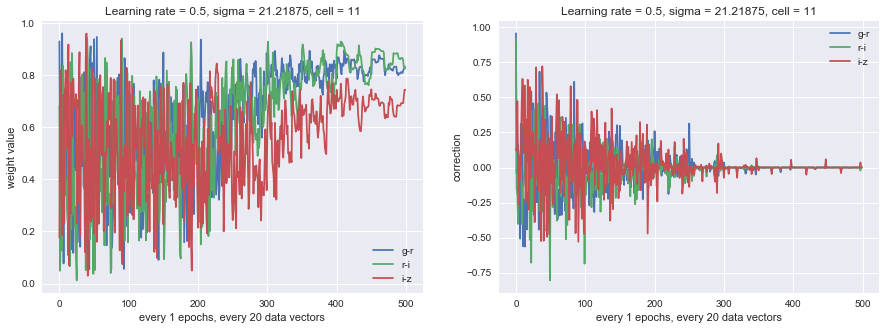

In [30]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=11, eta=0.5)

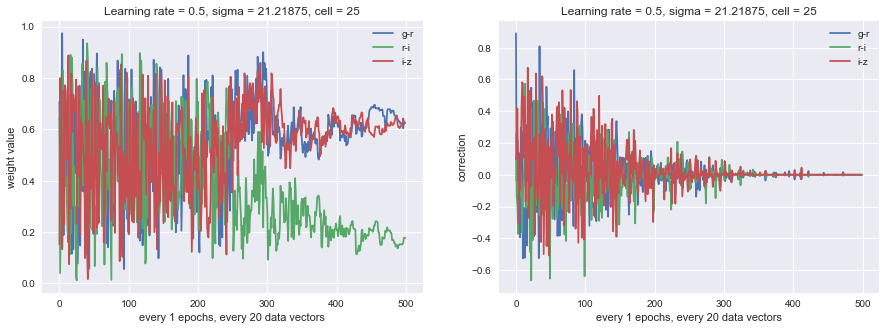

In [32]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=25, eta=0.5)

1.3950109481811523


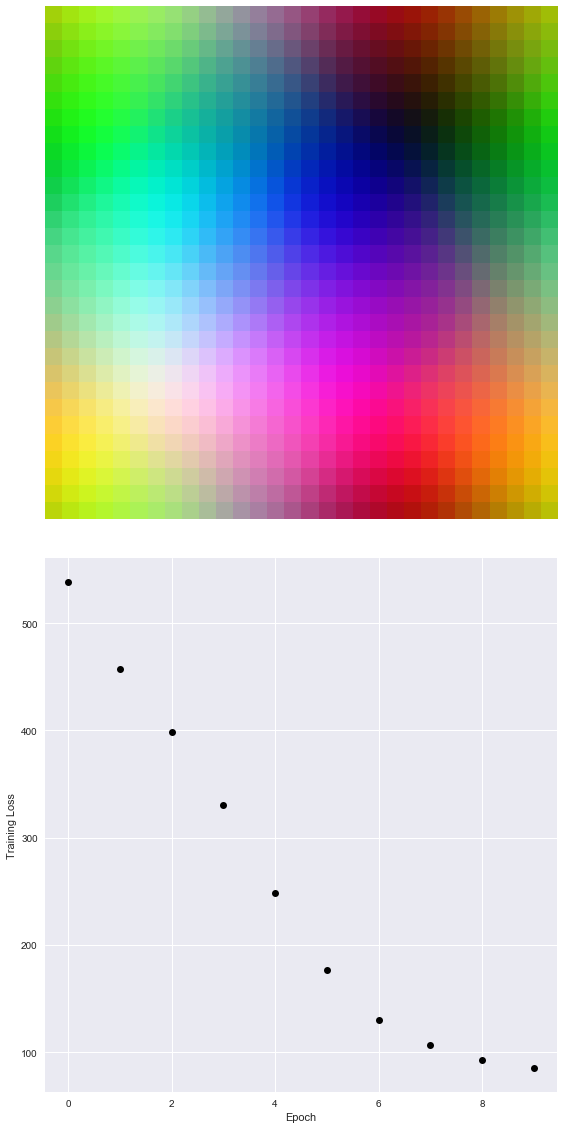

In [36]:
eta = 0.01
start = time.time()
rndm_som, rndm_weights = som.make_som(random_sample, nmap=-30, niter=10, rgb=[0,1,2], eta=eta)
print(time.time() - start)

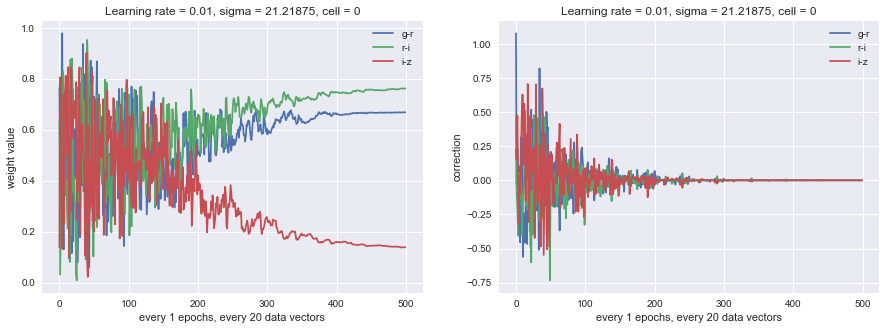

In [37]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=0, eta=eta)

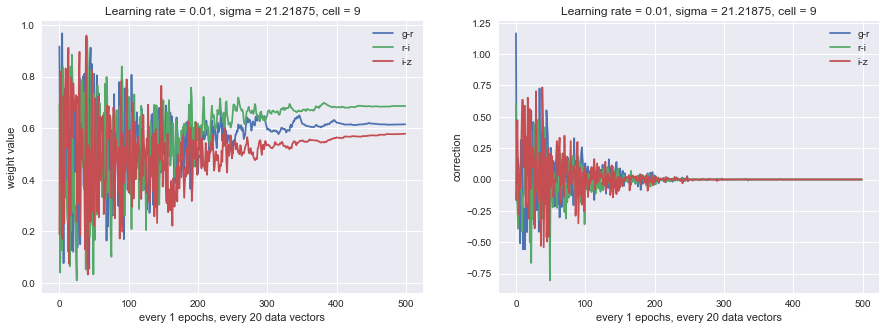

In [38]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=9, eta=eta)

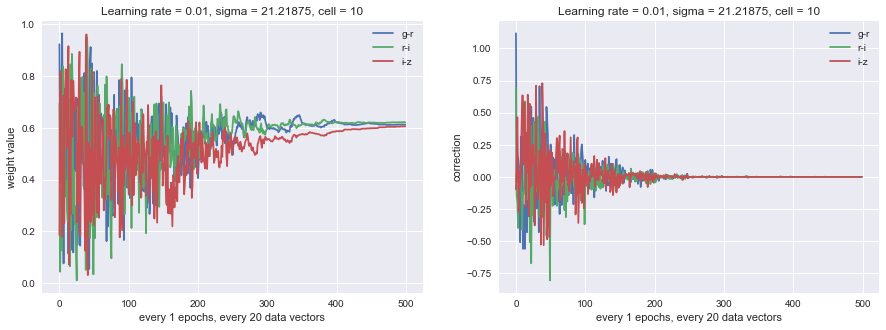

In [39]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=10, eta=eta)

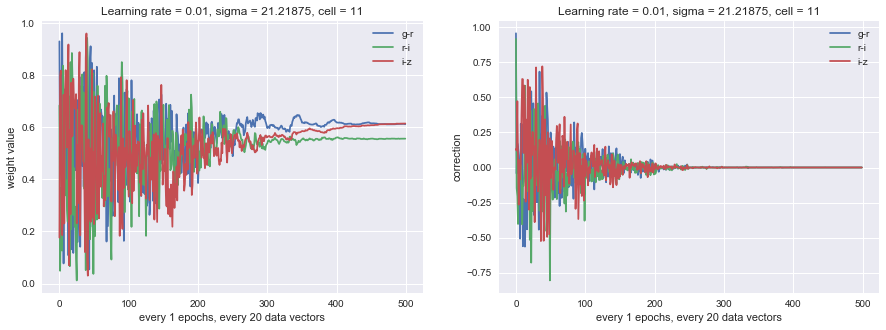

In [40]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=11, eta=eta)

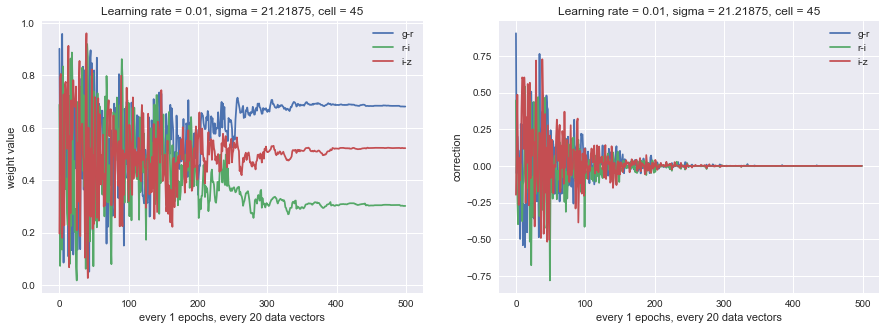

In [41]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=45, eta=eta)

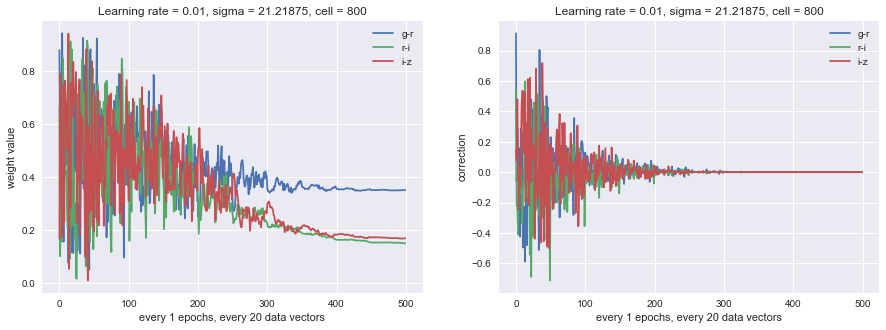

In [42]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=800, eta=eta)

Do cells on the 'edge' have similar trends?

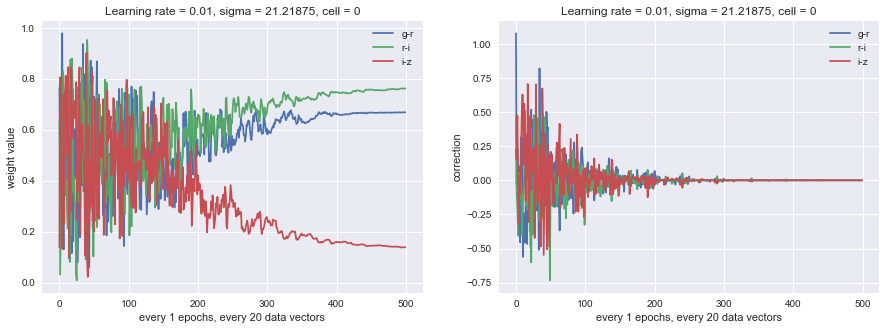

In [43]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=0, eta=eta)

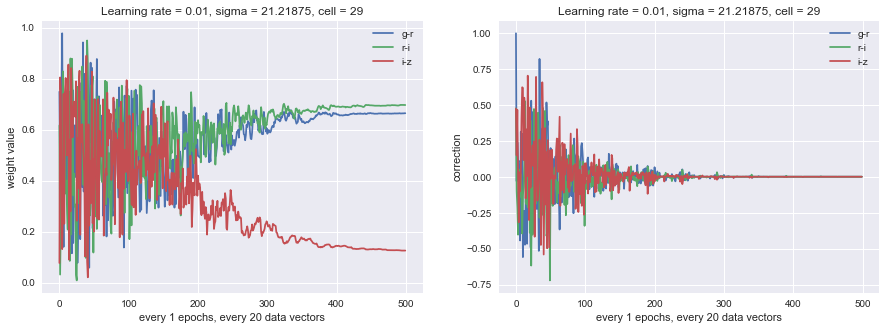

In [46]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=29, eta=eta)

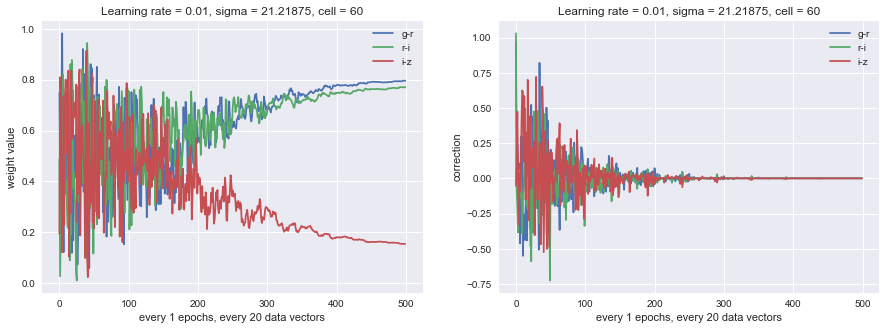

In [47]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=60, eta=eta)

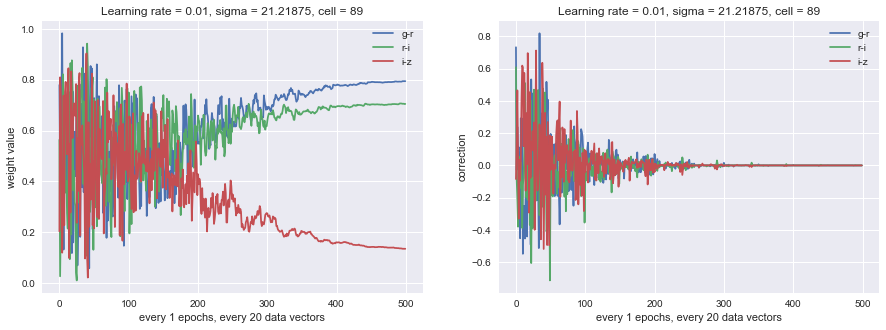

In [50]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=89, eta=eta)

1.2640180587768555


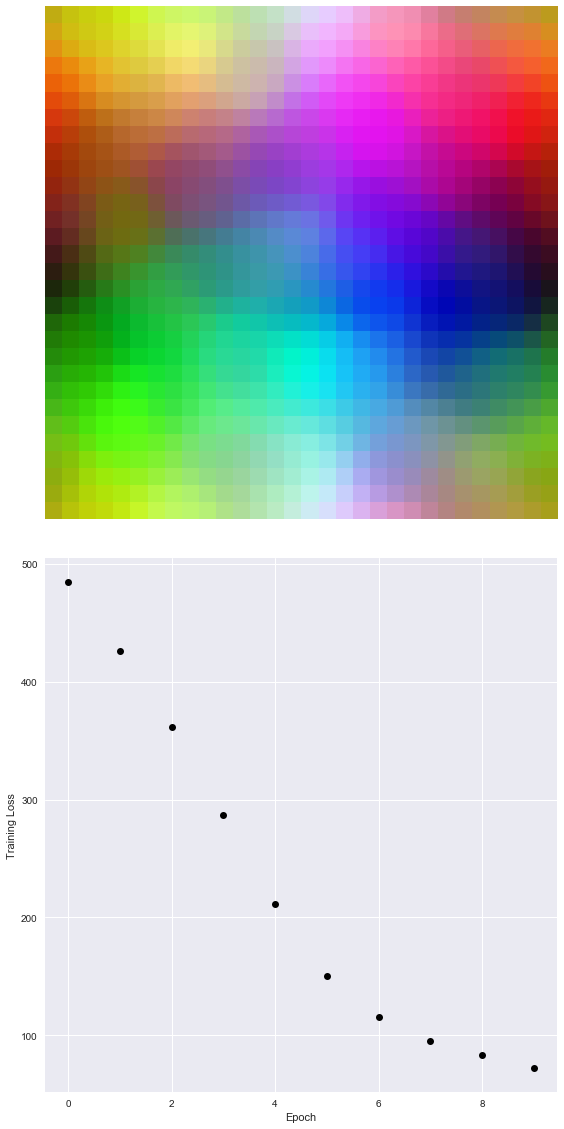

In [10]:
eta = 0.5
sigma_frac = 0.7
start = time.time()
rndm_som, rndm_weights = som.make_som(random_sample, nmap=-30, niter=10, rgb=[0,1,2], eta=eta, 
                                      sigma_frac=sigma_frac)
print(time.time() - start)

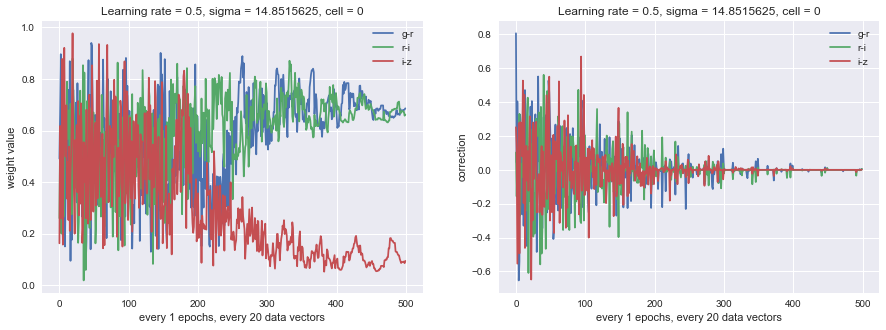

In [13]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=0, eta=eta)

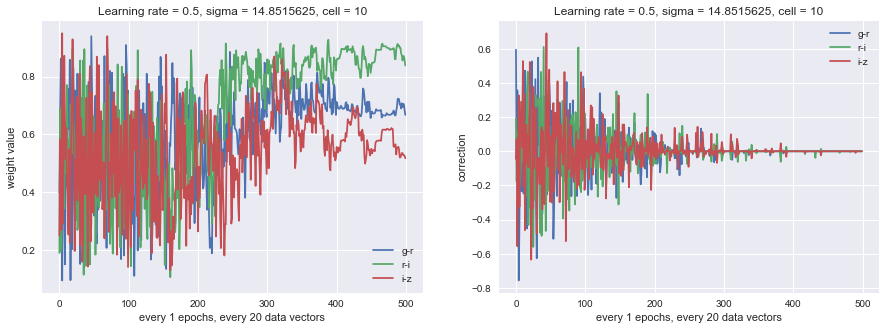

In [14]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=10, eta=eta)

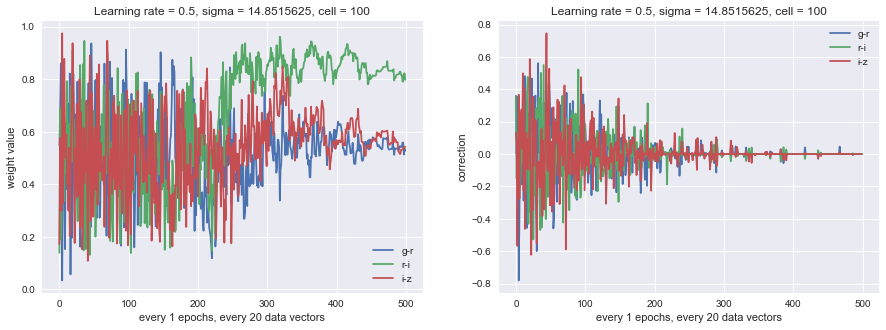

In [15]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=100, eta=eta)

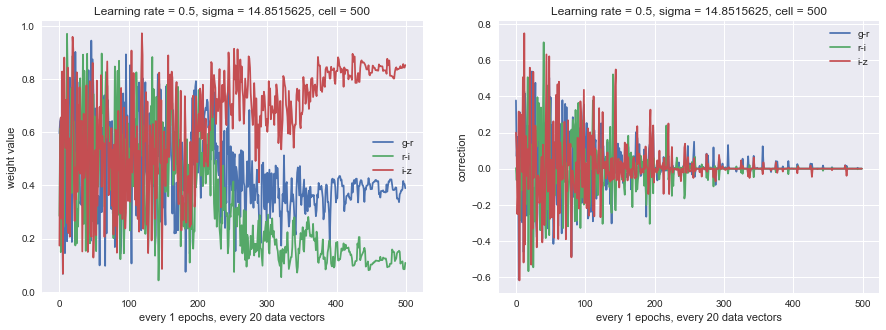

In [16]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=500, eta=eta)

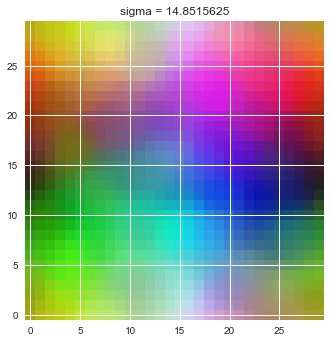

In [28]:
plt.imshow(rndm_som._weights.T.reshape(30,30,3), origin='lower', interpolation='none')
plt.title('sigma = {}'.format(rndm_som._scale.astype(float16)));

1.6553668975830078


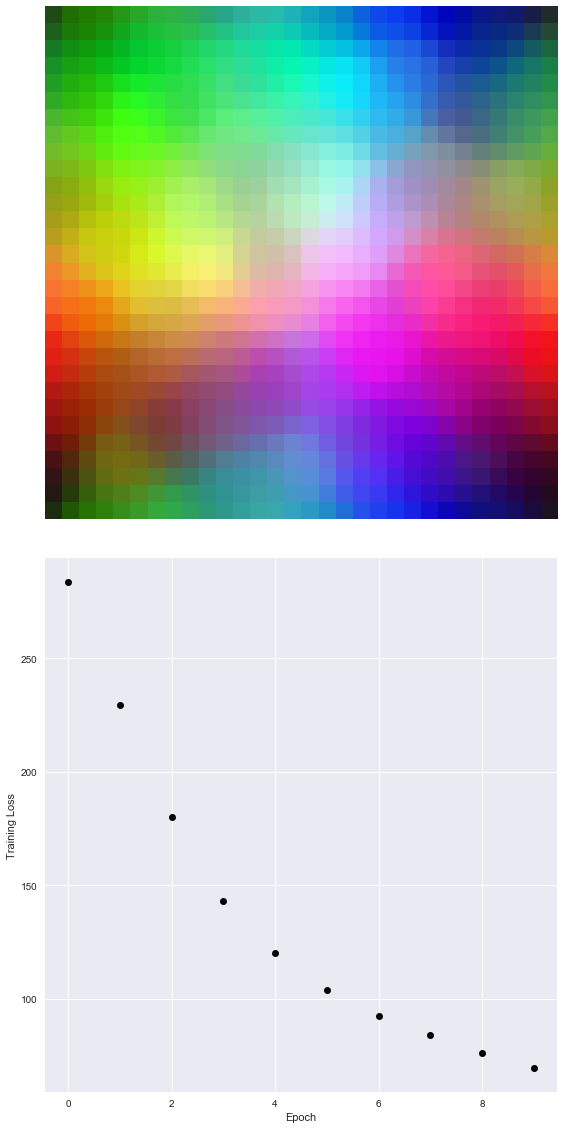

In [29]:
eta = 0.5
sigma_frac = 0.3
start = time.time()
rndm_som, rndm_weights = som.make_som(random_sample, nmap=-30, niter=10, rgb=[0,1,2], eta=eta, sigma_frac=sigma_frac)
print(time.time() - start)

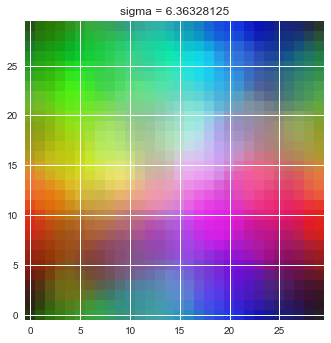

In [30]:
plt.imshow(rndm_som._weights.T.reshape(30,30,3), origin='lower', interpolation='none')
plt.title('sigma = {}'.format(rndm_som._scale.astype(float16)));

1.9800200462341309


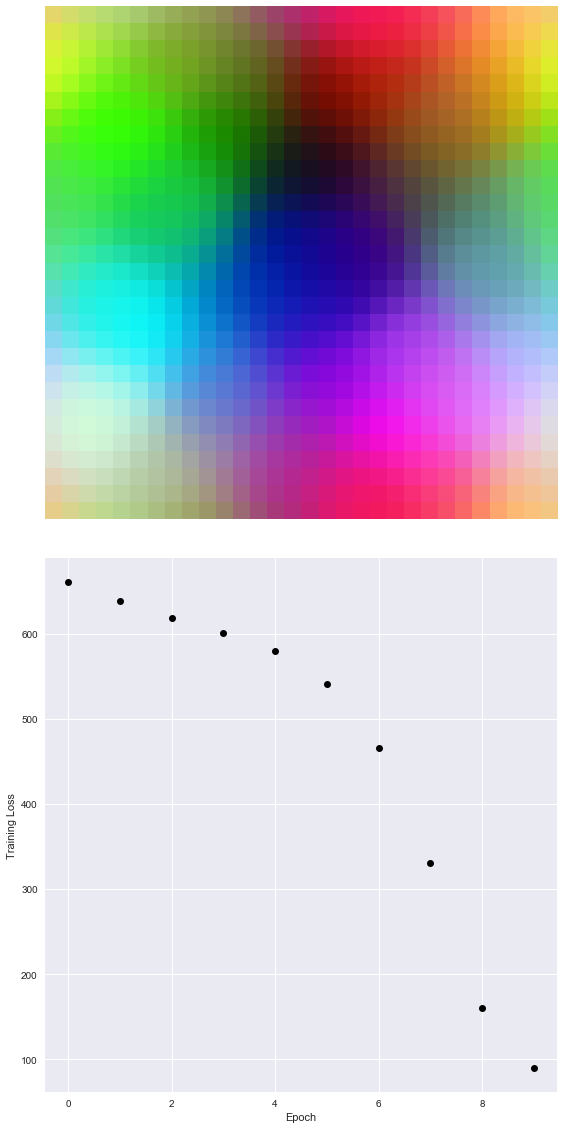

In [74]:
eta = 0.5
sigma_frac = 50
start = time.time()
rndm_som, rndm_weights = som.make_som(random_sample, nmap=-30, niter=10, rgb=[0,1,2], eta=eta, sigma_frac=sigma_frac)
print(time.time() - start)

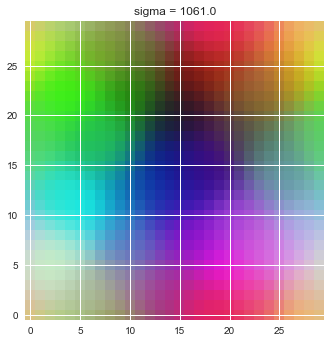

In [76]:
plt.imshow(rndm_som._weights.T.reshape(30,30,3), origin='lower', interpolation='none')
plt.title('sigma = {}'.format(rndm_som._scale.astype(float16)));

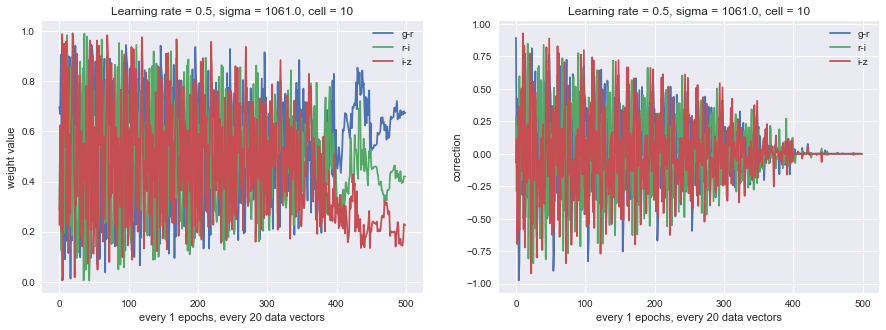

In [39]:
plot_evolution(rndm_som, nepoch=1, ndata=20, cell=10, eta=eta)

Ok, looks like things are working as expected with the random data. Now run on cosmoDC2:

In [128]:
len(random_sample), len(dc2_griz_colors[::50])

(1000, 32264)

27.965128183364868


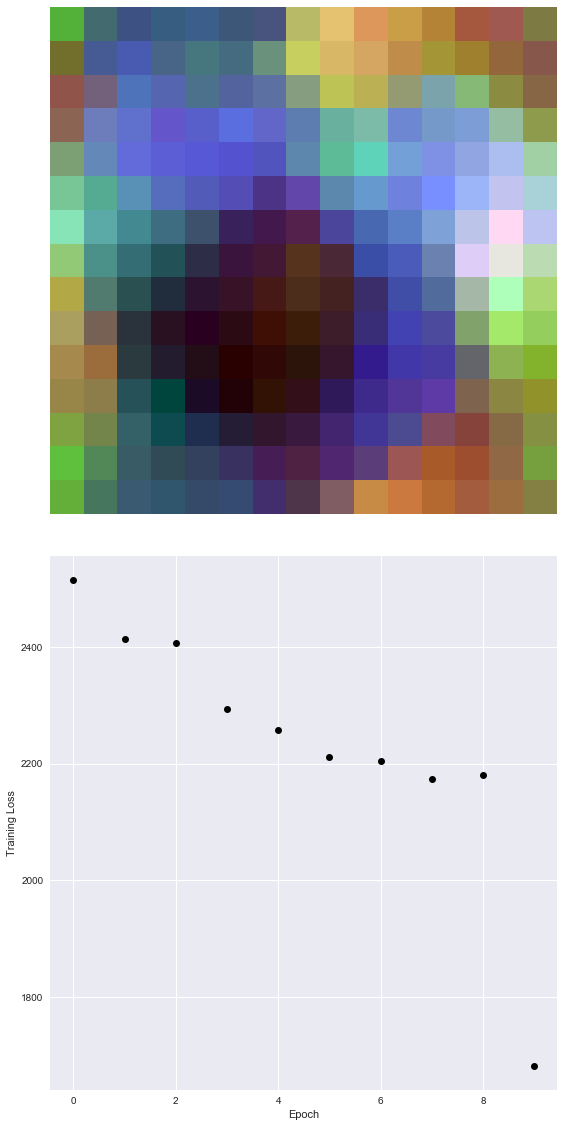

In [170]:
eta = 0.5
sigma_frac = 0.00001
start = time.time()
s, weights = som.make_som(dc2_griz_colors[::50], nmap=-15, niter=10, rgb=[0,1,2], eta=eta, 
                          sigma_frac=sigma_frac)
print(time.time() - start)

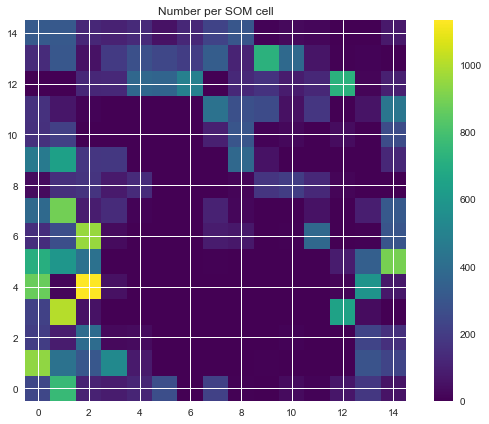

In [171]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights)

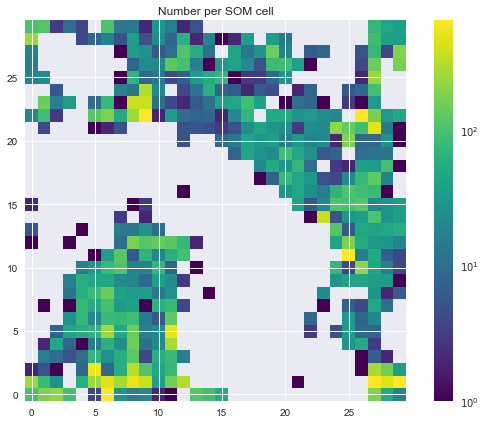

In [169]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights, norm=LogNorm(vmin=1,vmax=650))

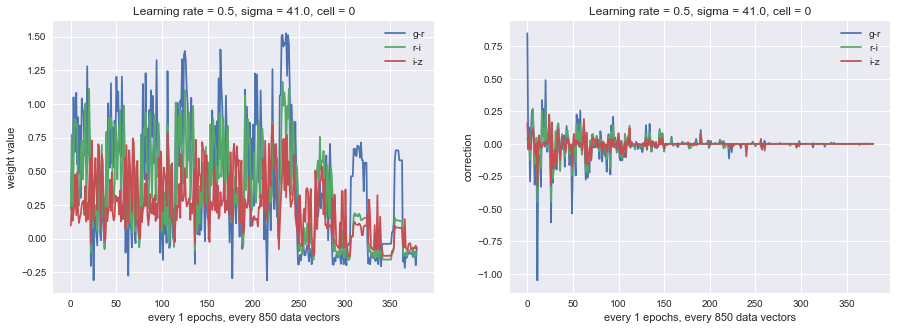

In [129]:
# non-periodic
plot_evolution(s, nepoch=1, ndata=850, cell=0, eta=eta)

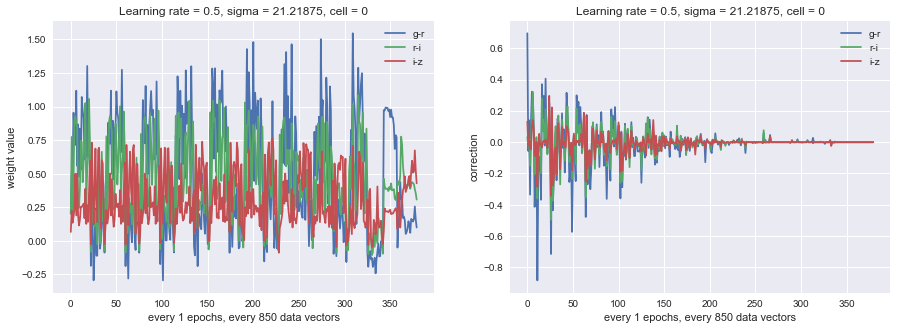

In [53]:
plot_evolution(s, nepoch=1, ndata=850, cell=0, eta=eta)

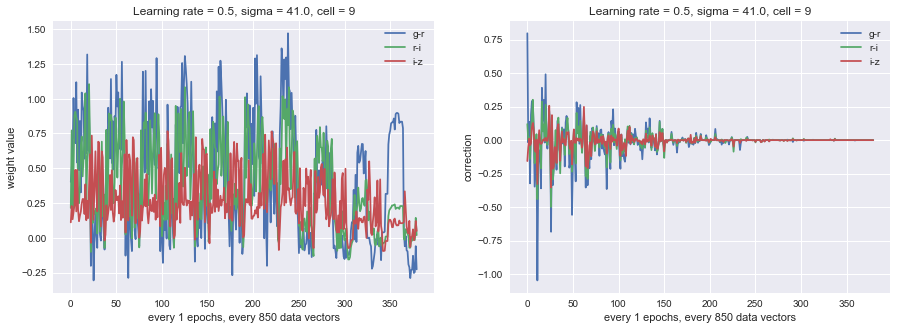

In [132]:
# non-periodic
plot_evolution(s, nepoch=1, ndata=850, cell=9, eta=eta)

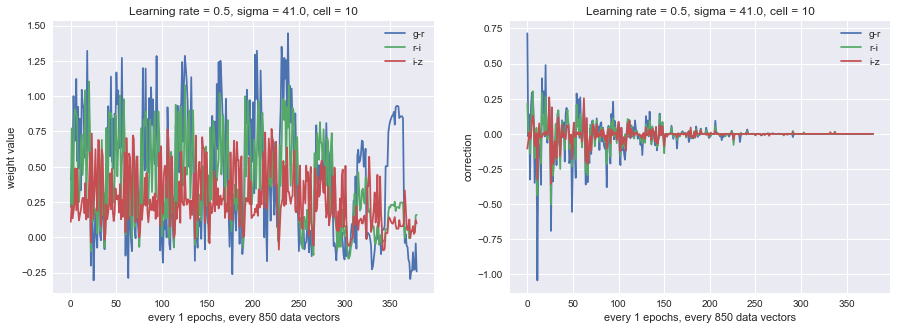

In [130]:
# non-periodic
plot_evolution(s, nepoch=1, ndata=850, cell=10, eta=eta)

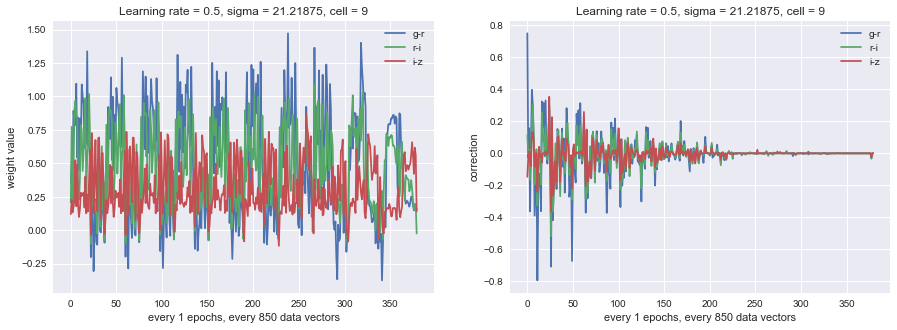

In [136]:
plot_evolution(s, nepoch=1, ndata=850, cell=9, eta=eta)

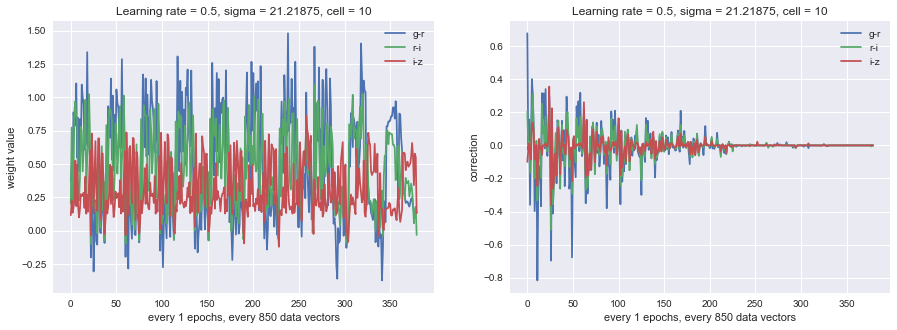

In [137]:
plot_evolution(s, nepoch=1, ndata=850, cell=10, eta=eta)

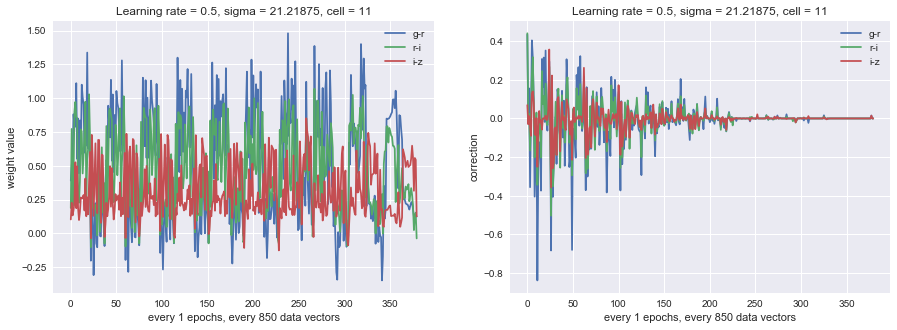

In [138]:
plot_evolution(s, nepoch=1, ndata=850, cell=11, eta=eta)

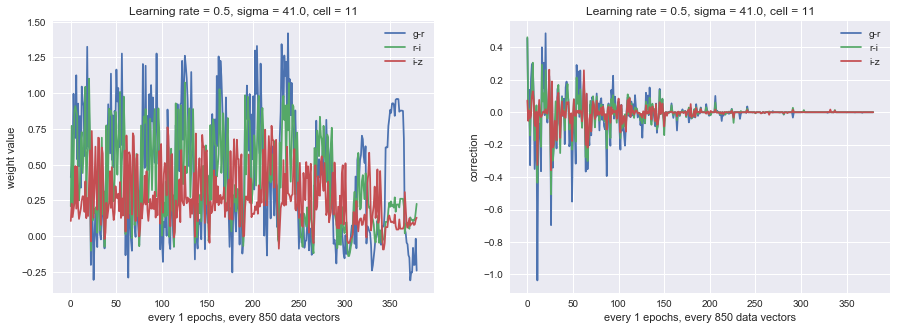

In [133]:
# non-periodic
plot_evolution(s, nepoch=1, ndata=850, cell=11, eta=eta)

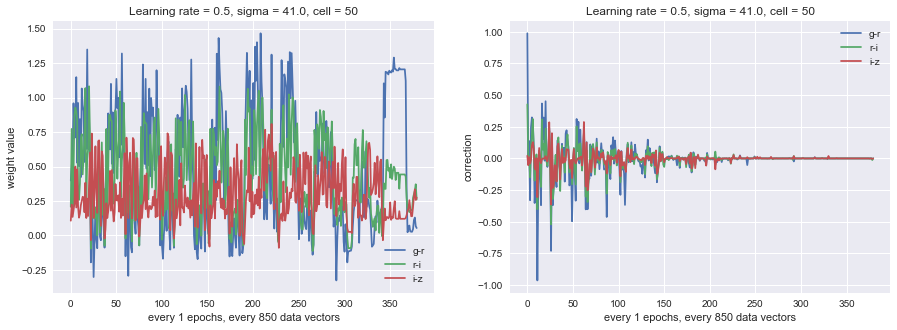

In [131]:
# non-periodic
plot_evolution(s, nepoch=1, ndata=850, cell=50, eta=eta)

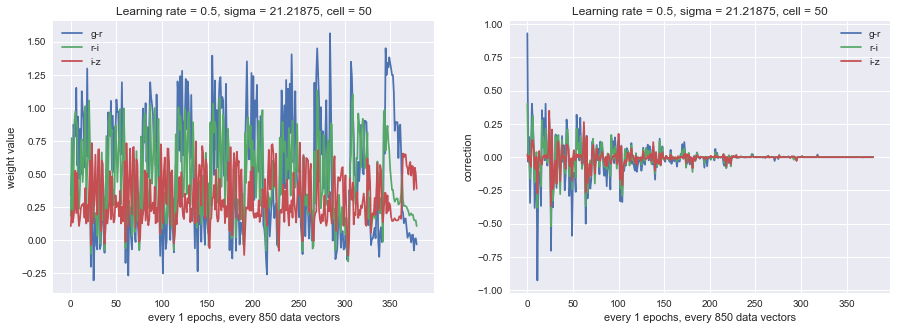

In [54]:
plot_evolution(s, nepoch=1, ndata=850, cell=50, eta=eta)

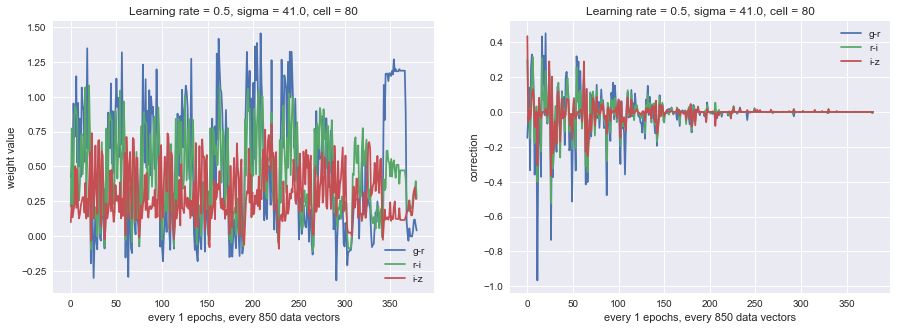

In [134]:
# non-periodic
plot_evolution(s, nepoch=1, ndata=850, cell=80, eta=eta)

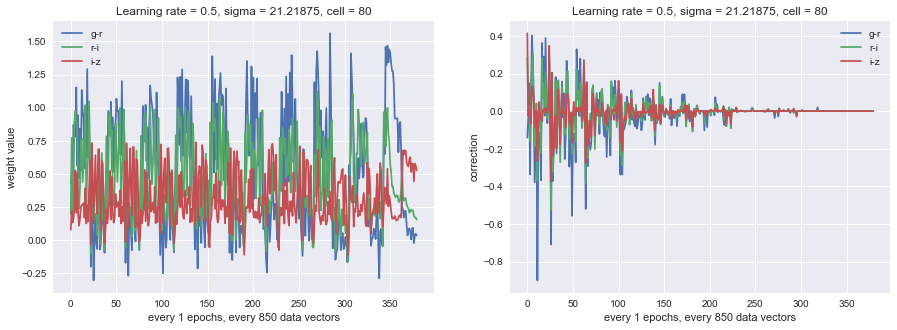

In [139]:
plot_evolution(s, nepoch=1, ndata=850, cell=80, eta=eta)

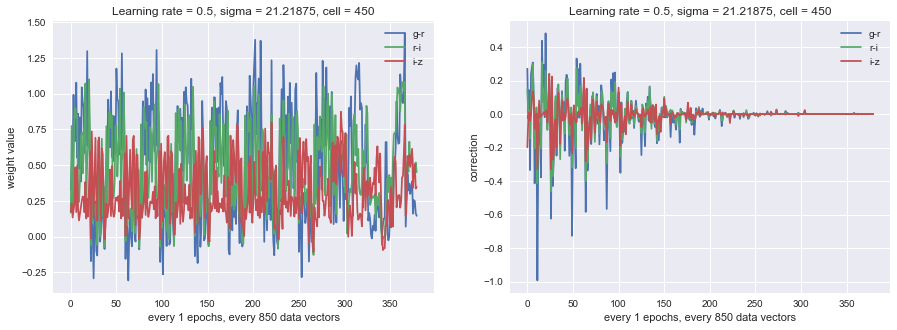

In [140]:
plot_evolution(s, nepoch=1, ndata=850, cell=450, eta=eta)

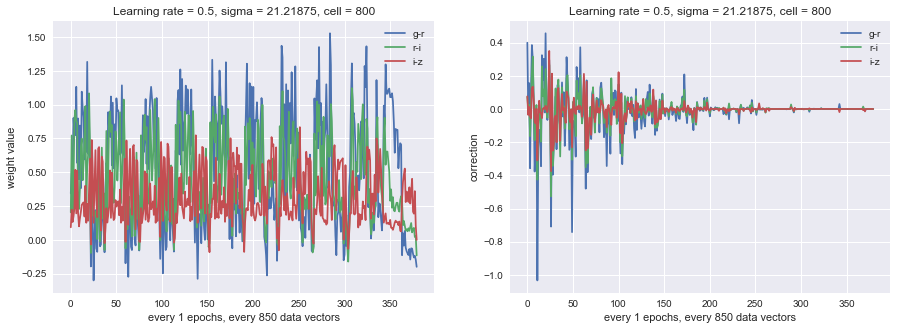

In [141]:
plot_evolution(s, nepoch=1, ndata=850, cell=800, eta=eta)

51.45701503753662


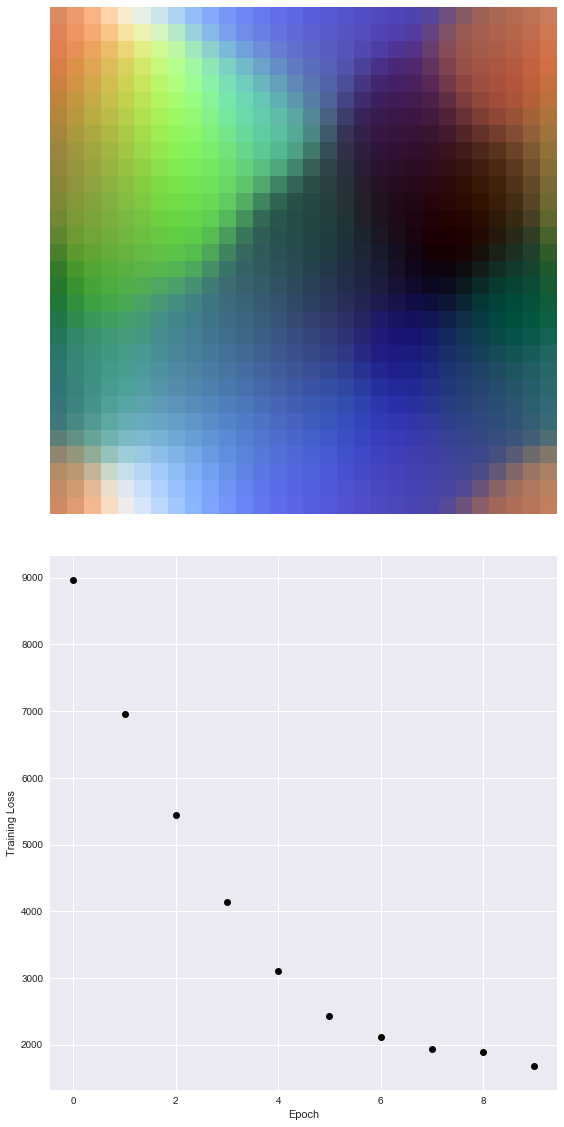

In [240]:
eta = 0.01
sigma_frac = 1
start = time.time()
s, weights = som.make_som(dc2_griz_colors[::50], nmap=-30, niter=10, rgb=[0,1,2], eta=eta, 
                                      sigma_frac=sigma_frac)
print(time.time() - start)

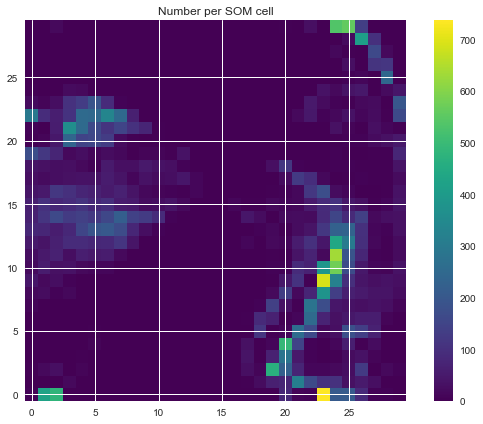

In [230]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights)

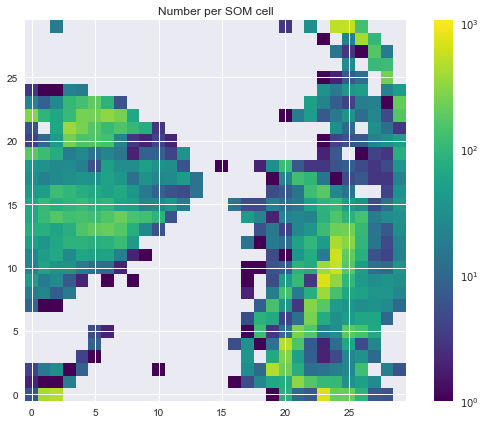

In [231]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights, norm=LogNorm(vmin=1, vmax=1050))

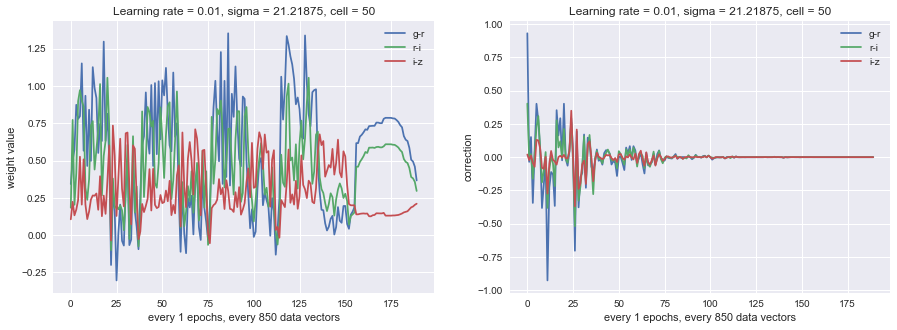

In [236]:
plot_evolution(s, nepoch=1, ndata=850, cell=50, eta=eta)

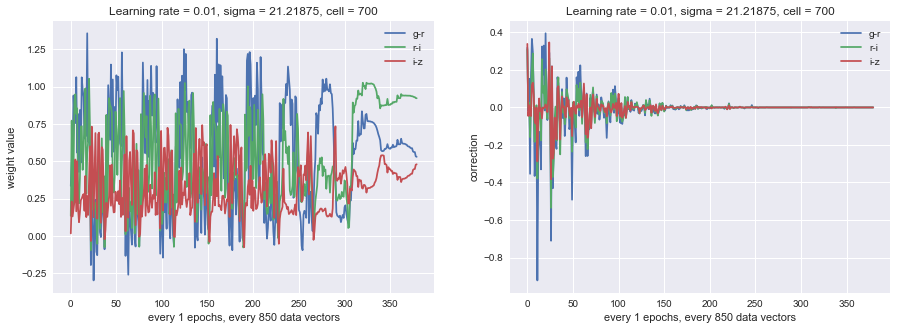

In [241]:
plot_evolution(s, nepoch=1, ndata=850, cell=700, eta=eta)

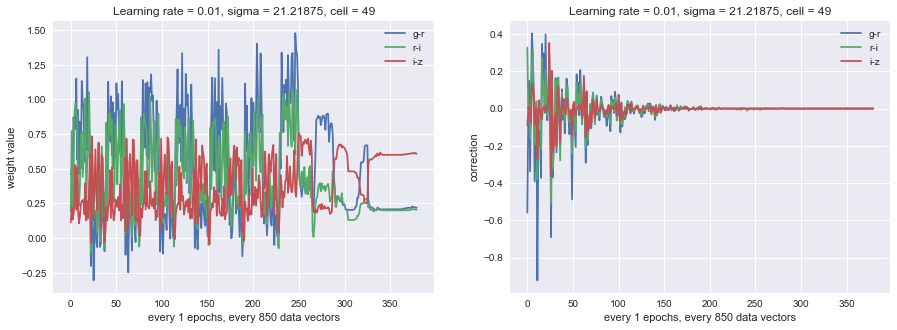

In [212]:
plot_evolution(s, nepoch=1, ndata=850, cell=49, eta=eta)

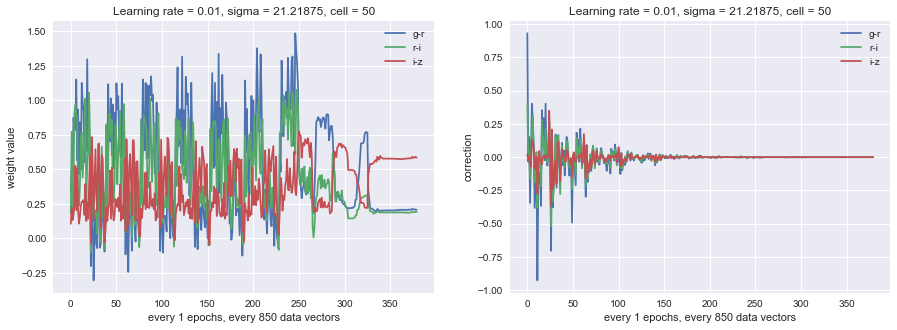

In [213]:
plot_evolution(s, nepoch=1, ndata=850, cell=50, eta=eta)

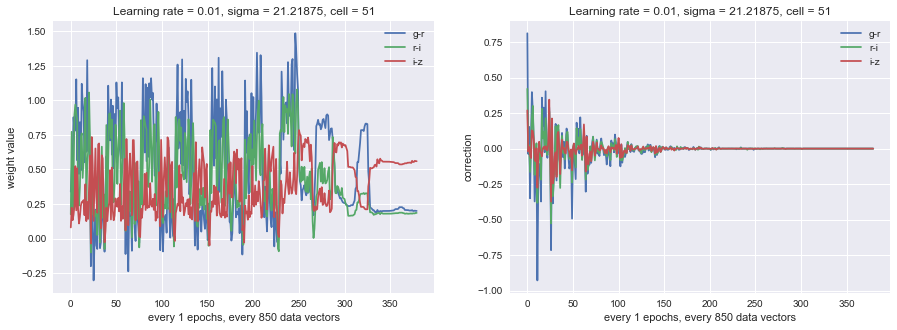

In [214]:
plot_evolution(s, nepoch=1, ndata=850, cell=51, eta=eta)

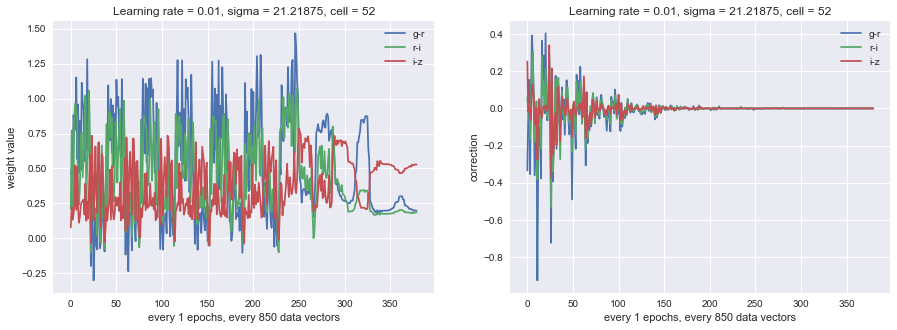

In [215]:
plot_evolution(s, nepoch=1, ndata=850, cell=52, eta=eta)

58.69650387763977


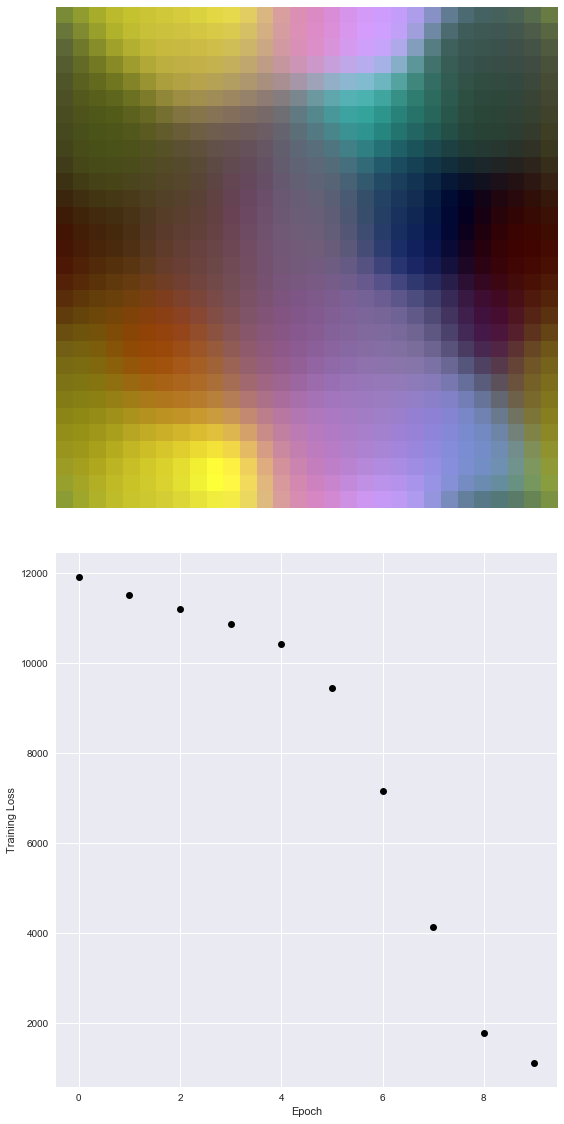

In [143]:
eta = 0.5
sigma_frac = 50
start = time.time()
s, weights = som.make_som(dc2_griz_colors[::50], nmap=-30, niter=10, rgb=[0,1,2], eta=eta, 
                          sigma_frac=sigma_frac)
print(time.time() - start)

In [144]:
s._scale

1060.6601717798212

50.053946018218994


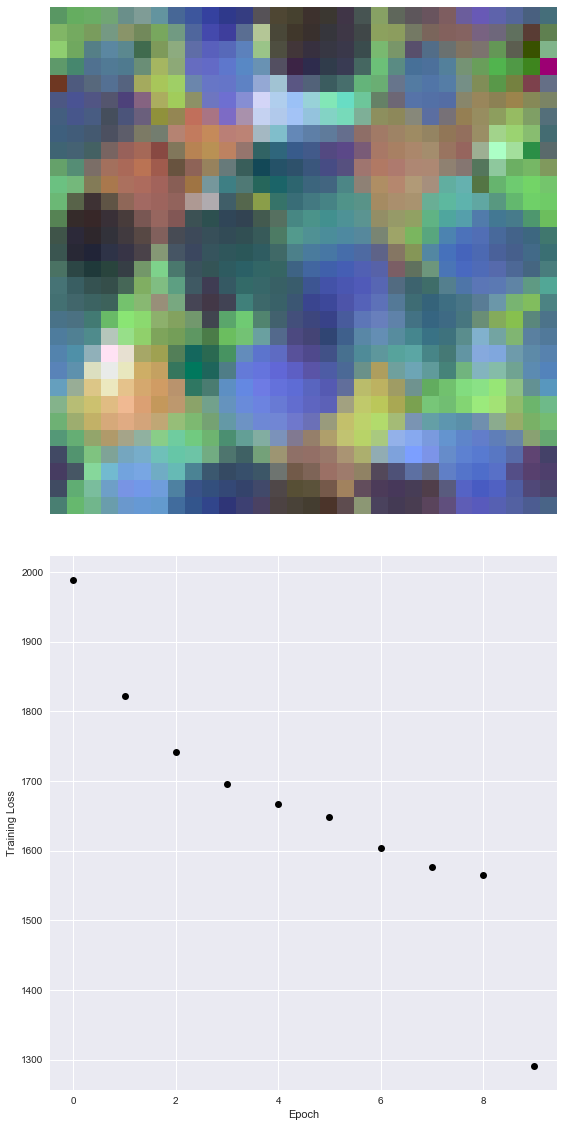

In [142]:
eta = 0.5
sigma_frac = 0.00001
start = time.time()
s, weights = som.make_som(dc2_griz_colors[::50], nmap=-30, niter=10, rgb=[0,1,2], eta=eta, 
                          sigma_frac=sigma_frac)
print(time.time() - start)

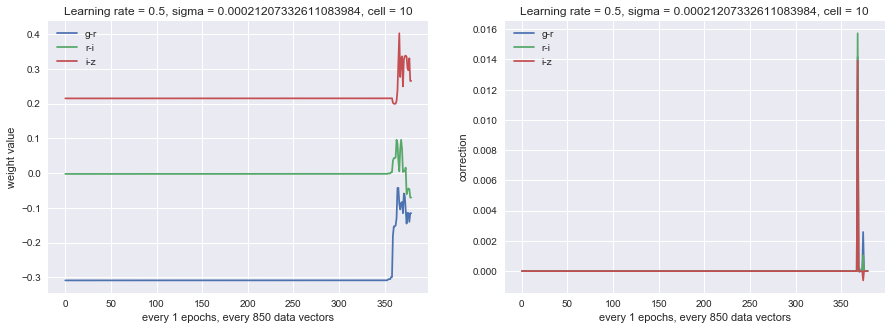

In [50]:
plot_evolution(s, nepoch=1, ndata=850, cell=10, eta=eta)

53.424907207489014


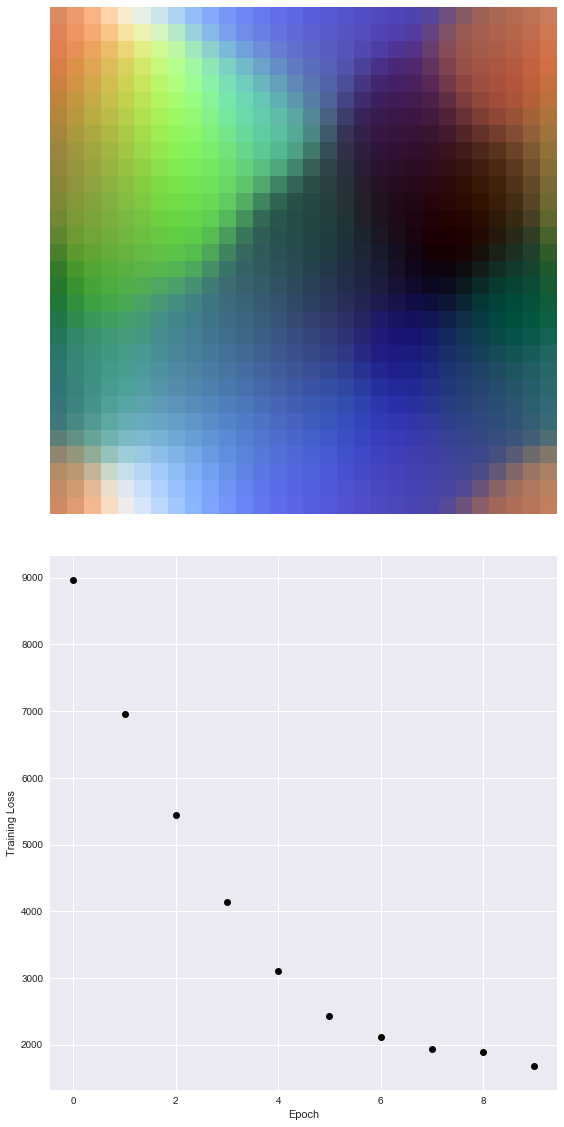

In [145]:
eta = 0.01
sigma_frac = 1
start = time.time()
s, weights = som.make_som(dc2_griz_colors[::50], nmap=-30, niter=10, rgb=[0,1,2], eta=eta, sigma_frac=sigma_frac)
print(time.time() - start)

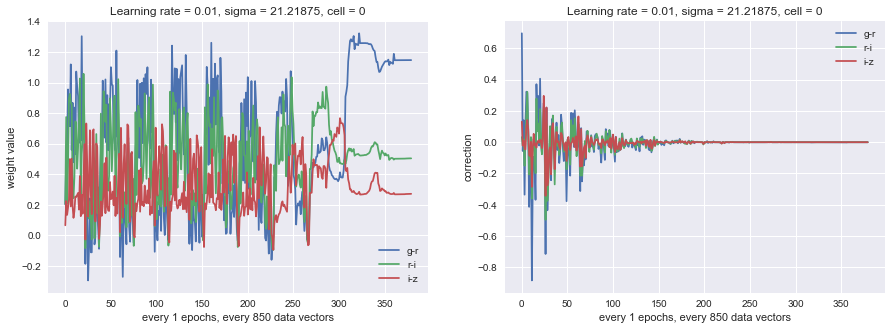

In [146]:
plot_evolution(s, nepoch=1, ndata=850, cell=0, eta=eta)

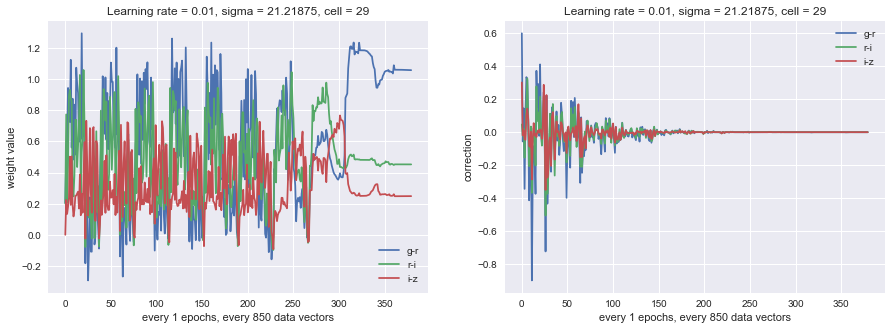

In [147]:
plot_evolution(s, nepoch=1, ndata=850, cell=29, eta=eta)

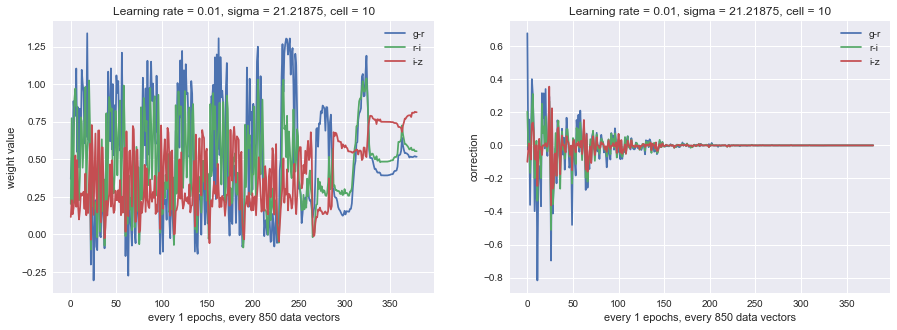

In [148]:
plot_evolution(s, nepoch=1, ndata=850, cell=10, eta=eta)

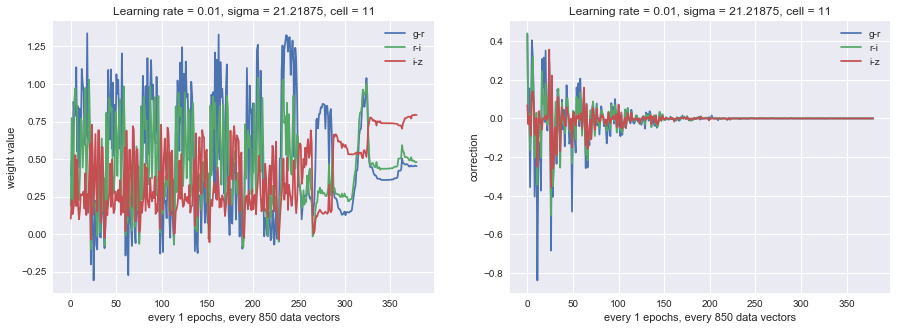

In [149]:
plot_evolution(s, nepoch=1, ndata=850, cell=11, eta=eta)

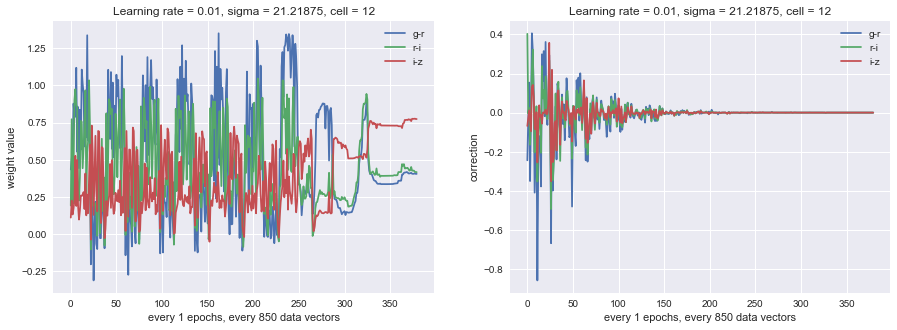

In [150]:
plot_evolution(s, nepoch=1, ndata=850, cell=12, eta=eta)

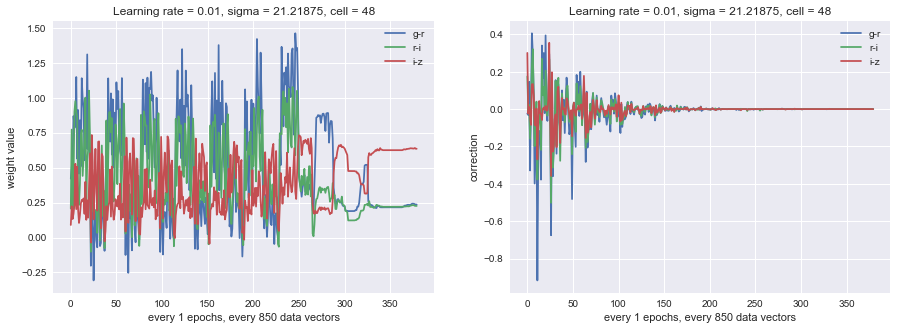

In [151]:
plot_evolution(s, nepoch=1, ndata=850, cell=48, eta=eta)

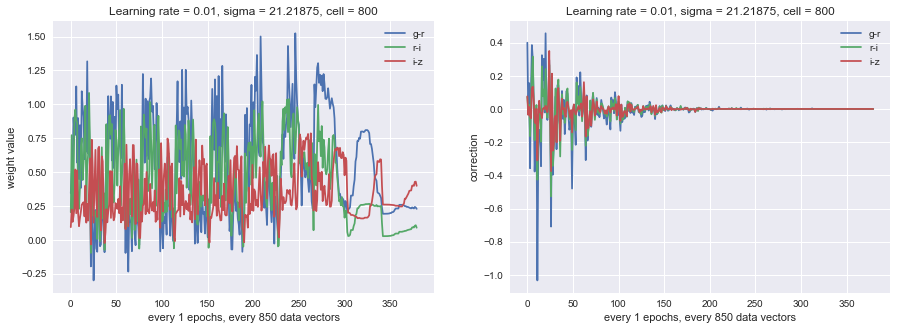

In [152]:
plot_evolution(s, nepoch=1, ndata=850, cell=800, eta=eta)

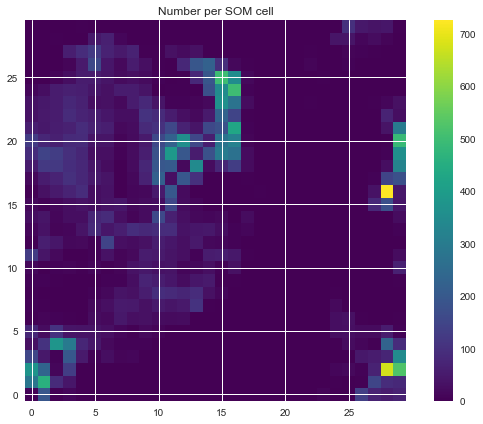

In [153]:
som.plot_counts_per_cell(dc2_griz_colors[::50], weights)